# VarClump2D: Concept test

## _Without optimizations..._

In [1]:
%matplotlib inline

import sys
import numba
#import matlab.engine
import numpy as np
import scipy as sp
import sympy as sym
import numexpr as ne
from math import sqrt, log, floor, ceil
import matplotlib.pyplot as plt
from scipy import interpolate, optimize
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.cluster import KMeans

# acalib helper functions
sys.path.append('../../ACALIB/')
from acalib import load_fits, standarize

# extra metric module
import custom_metric as cm

/home/martin/miniconda2/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


## Helpers computing functions

In [2]:
"""
Computes RMS value of N-dimensional numpy array
"""
def estimate_rms(data):
    ret = np.sum(data*data) / np.size(data)
    return np.sqrt(ret)


def estimate_entropy(data):
    # estimation of probabilities
    p = np.histogram(data.ravel(), bins=256, density=False)[0].astype(float)
    p /= p.sum()
    # computation of entropy 
    return -np.sum(p * np.log2(p))


def estimate_variance(data):
    return np.std(data)**2


def compute_residual_stats(c, sig, xc, yc, base_level=0., square_c=True, compact_supp=True, resolution=5):
    _xe = np.linspace(0., 1., 41*resolution)[1:-1]
    _ye = np.linspace(0., 1., 41*resolution)[1:-1]
    len_xe = len(_xe); len_ye = len(_ye)
    Xe,Ye = np.meshgrid(_xe, _ye, sparse=False)
    xe = Xe.ravel(); ye = Ye.ravel()
    Nc = len(xc)
    Ne = len(xe)
    
    """ 
    Computing distance matrices
    """
    #distance matrices
    Dx = np.empty((Ne,Nc))
    Dy = np.empty((Ne,Nc))
    for k in range(Ne):
        Dx[k,:] = xe[k]-xc
        Dy[k,:] = ye[k]-yc
    """
    Computing the Phi matrix
    """
    if square_c: c = c**2
    if compact_supp: phi_m = phi(Dx, Dy, sig.reshape(1,-1))
    else: phi_m = phi(Dx, Dy, sig.reshape(1,-1), supp=0.)
    u = np.dot(phi_m, c) + base_level
    u = u.reshape(len_xe, len_ye)

    residual = f(_xe, _ye)-u
    return (estimate_variance(residual), 
            estimate_entropy(residual),
            estimate_rms(residual))

## Helpers visualization functions

In [3]:
"""
Helper function to visualize the quality of the solution
"""
def plotter(c, sig, xc, resolution=10, title=None):
    _xe = np.linspace(0., 1., 10*N, endpoint=True)
    _Dx = np.empty((10*N,N))
    for k in range(10*N):
        _Dx[k,:] = (_xe[k] - xc)

    phi_m = phi(_Dx, sig)
    u = np.dot(phi_m, c)
    plt.figure(figsize=(10,6))
    plt.plot(_xe, u, 'r-', label='Solution')
    plt.plot(x_, f(x_), 'b--', label='Data')
    plt.plot(xe, f(xe), 'go', label='Evaluation points')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.3, 1.0))
    plt.show()

def plot_sol(c, sig, xc, yc, base_level=0., square_c=True, resolution=5, title=None, compact_supp=True):
    _xe = np.linspace(0., 1., 41*resolution)[1:-1]
    _ye = np.linspace(0., 1., 41*resolution)[1:-1]
    len_xe = len(_xe); len_ye = len(_ye)
    Xe,Ye = np.meshgrid(_xe, _ye, sparse=False)
    xe = Xe.ravel(); ye = Ye.ravel()
    Nc = len(xc)
    Ne = len(xe)
    
    """ 
    Computing distance matrices
    """
    #distance matrices
    Dx = np.empty((Ne,Nc))
    Dy = np.empty((Ne,Nc))
    for k in range(Ne):
        Dx[k,:] = xe[k]-xc
        Dy[k,:] = ye[k]-yc
    """
    Computing the Phi matrix
    """
    if square_c: c = c**2
    if compact_supp: phi_m = phi(Dx, Dy, sig.reshape(1,-1))
    else: phi_m = phi(Dx, Dy, sig.reshape(1,-1), supp=0.)
    u = np.dot(phi_m, c) + base_level
    u = u.reshape(len_xe, len_ye)

    """
    2D plot
    """
    plt.figure(figsize=(18,12))
    plt.subplot(1,3,1)
    ax = plt.gca()
    im = ax.imshow(f(_xe, _ye))
    #plt.imshow(np.log10(np.abs(u)+1e-10))
    plt.title('Original')
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
    """
    2D plot
    """
    plt.subplot(1,3,2)
    ax = plt.gca()
    im = ax.imshow(u)
    #plt.imshow(np.log10(np.abs(u)+1e-10))
    plt.title('Solution')
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
    """
    2D plot
    """
    plt.subplot(1,3,3)
    ax = plt.gca()
    im = ax.imshow(f(_xe, _ye)-u)
    #plt.imshow(np.log10(np.abs(u)+1e-10))
    plt.title('Residual')
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()
    
    #X,Y = np.meshgrid(_xe, _ye,sparse=True)
    #fig = plt.figure(figsize=(15,8))
    #ax = fig.add_subplot(111, projection='3d')
    #ax.plot_surface(X, Y, u, linewidth=0.1, cmap='jet')
    #ax.set_xlabel('x')
    #ax.set_ylabel('y')
    #ax.set_zlabel('I')
    #plt.title('Solution')
    #plt.show()
    residual = f(_xe, _ye)-u
    return (estimate_variance(residual), 
            estimate_entropy(residual),
            estimate_rms(residual))

def params_plot(c, sig, xc, yc, square_c=True):
    if square_c: c = c**2
    plt.figure(figsize=(17,7))
    plt.subplot(1,2,1)
    plt.title('Plot of c parameters')
    plt.xlim(-0.01,1.01)
    plt.ylim(-0.01,1.01)
    plt.scatter(xc, yc, c=c)
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.title('Plot of sig^2 parameters')
    plt.xlim(-0.01,1.01)
    plt.ylim(-0.01,1.01)
    plt.scatter(xc, yc, c=sig**2)
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.show()
    
def params_distribution_plot(c, sig, square_c=True, percentile=100.):
    if square_c: c = c**2
    plt.figure(figsize=(14,7))
    plt.subplot(1,2,1)
    plt.title('C distribution')
    plt.hist(c, color='grey', bins=10)
    plt.subplot(1,2,2)
    plt.title('Sig^2 distribution')
    plt.hist(sig**2, color='grey', bins=10)
    plt.show()

def residual_plot(residual_variance, residual_entropy, residual_rms, iter_list):
    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.xlim(0, iter_list[-1]+iter_list[0])
    plt.plot(iter_list, residual_rms, 'go-')
    plt.title('Residual RMS')        
    plt.subplot(1,3,2)
    plt.xlim(0, iter_list[-1]+iter_list[0])
    plt.plot(iter_list, residual_variance, 'bo-')
    plt.title('Residual variance')
    plt.subplot(1,3,3)
    plt.xlim(0, iter_list[-1]+iter_list[0])
    plt.plot(iter_list, residual_entropy, 'ro-')
    plt.title('Residual entropy')
    plt.show()

## Loading data 2D: Stacking on frequency

In [4]:
"""
Loading data
"""

#fit_path = '../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits'
#fit_path = '../../bindata/fits/cubes/M100line.image.fits'
fit_path = '../../ACALIB/bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits'
#fit_path = '../../bindata/fits/cubes/ALMA01000740.fits'
container = load_fits(fit_path)
data = standarize(container.primary)[0]
data = data.data

#stacking it
data = data.sum(axis=0)
data /= data.max()

INFO: Processing HDU 0 (Image) [acalib.io.fits]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.fits]
INFO: NDData was created with a masked array, and a mask was explicitly provided to NDData. The  explicitly passed-in mask will be used and the masked array's mask will be ignored. [astropy.nddata.nddata]


In [5]:
"""
Generating the data function
"""
x = np.linspace(0., 1., len(data[0]), endpoint=True)
y = np.linspace(0., 1., len(data[1]), endpoint=True)
f = sp.interpolate.interp2d(x, y, data, kind='linear')

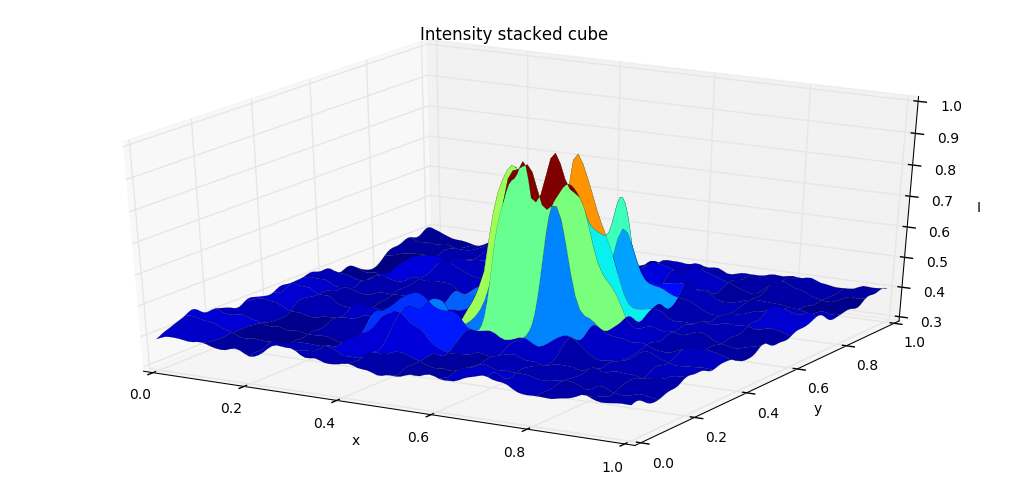

In [6]:
X,Y = np.meshgrid(x,y,sparse=True)
#3d plot
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, data, linewidth=0.1, cmap='jet')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('I')
plt.title('Intensity stacked cube')
plt.show()

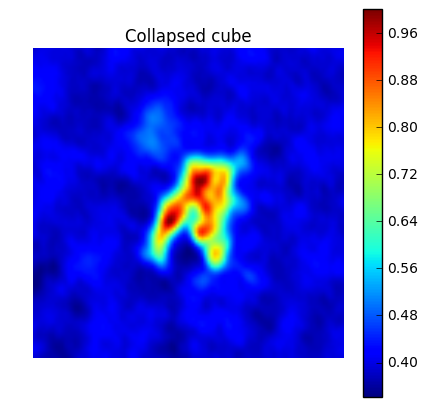

In [7]:
plt.figure(figsize=(5,5))
plt.imshow(data)
plt.title('Collapsed cube')
plt.axis('off')
plt.colorbar()
plt.show()

## Euler-Lagrange Derivation

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}} L(x, y, u, u_x, u_y) \ d\Omega  = \int_{\Omega \subset \mathbb{R}}(u(x,y)-f_0(x,y))^2 + \alpha \ \Psi_1(u(x,y)-f_0(x,y)) + \beta \ \Psi_2(\left|\nabla u(x,y)\right|^2) \ d\Omega $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$
\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} - \frac{d}{dy}\frac{\partial L}{\partial u_y}= 0$$

$$
2(u-f) + \alpha \Psi_1'(u-f) -2\beta \Big( 2\Psi_2''(u_x^2+u_y^2) \left[(u_x u_{xx} + u_y u_{yx})u_x + (u_x u_{xy} + u_y u_{yy})u_y \right] + \Psi_2'(u_x^2 + u_y^2) \left[u_{xx}+u_{yy} \right] \Big) = 0
$$

whit boundary condition $u(\partial \Omega) = f(\partial \Omega)$. The proposed solution has the form of a linear combination of Gaussian functions:

$$u(x,y) = \sum_{i=1}^N c_i \ \phi(x, y;\ x_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2 + (y-y_i)^2}{2 \sigma_i^2}}$$

## Defining and computing the penalizing functions $\Psi_1$ and $\Psi_2$ (they will be the same)

In [8]:
"""
General Psi penalizing function (applicable in both cases)
"""
def psi(x, lamb=1.):
    x = lamb*x
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 1.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('10*x**3 - 15*x**4 + 6*x**5')
    return ret

def d1psi(x, lamb=1.):
    x = lamb*x
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 0.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('30*x**2 - 60*x**3 + 30*x**4')
    return lamb*ret

def d2psi(x, lamb=1.):
    x = lamb*x
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 0.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('60*x - 180*x**2 + 120*x**3')
    return (lamb**2)*ret

## $\phi$-RBF function to use and its derivatives

In [9]:
#minimal broadening of gaussians
minsig = 0.001

"""
RBF (Gaussian) functions and its derivatives
"""
def phi(x, y, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('exp(-(x**2+y**2)/(2*(sig0**2+sig**2)))')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2)] = 0.
    return retval

def phix(x, y, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(-1./(sig0**2+sig**2)) * exp(-(x**2+y**2)/(2*(sig0**2+sig**2))) * x')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

def phiy(x, y, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(-1./(sig0**2+sig**2)) * exp(-(x**2+y**2)/(2*(sig0**2+sig**2))) * y')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

#same as phiyx
def phixy(x, y, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(1./(sig0**2+sig**2)**2) * exp(-(x**2+y**2)/(2*(sig0**2+sig**2))) * (x*y)')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

def phixx(x, y, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(1./(sig0**2+sig**2)**2) * exp(-(x**2+y**2)/(2*(sig0**2+sig**2))) * (x**2 - sig0**2 - sig**2)')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

def phiyy(x, y, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(1./(sig0**2+sig**2)**2) * exp(-(x**2+y**2)/(2*(sig0**2+sig**2))) * (y**2 - sig0**2 - sig**2)')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

## Euler-Lagrange function class definition

In [10]:
class ELFunc():
    def __init__(self, f, xe, ye, xc, yc, xb, yb, c0, sig0, d1psi1=None, d1psi2=None, d2psi2=None,
                 a=0., b=0., lamb1=1., lamb2=1., base_level=0, square_c=True, compact_supp=False):
        f0 = np.array([f(xe[i],ye[i]) for i in range(len(xe))]).ravel()
        fb = np.array([f(xb[i],yb[i]) for i in range(len(xb))]).ravel()
        len_f0 = len(f0)
        len_c0 = len(c0)
        len_sig0 = len(sig0)
        Ne = len(xe)
        Nc = len(xc)
        Nb = len(xb)

        """ 
        Computing distance matrices
        """
        #distance matrices
        Dx = np.empty((Ne,Nc))
        Dy = np.empty((Ne,Nc))
        for k in range(Ne):
            Dx[k,:] = xe[k]-xc
            Dy[k,:] = ye[k]-yc
        #distance matrices for boundary points
        Dxb = np.empty((Nb,Nc))
        Dyb = np.empty((Nb,Nc))
        for k in range(Nb):
            Dxb[k,:] = xb[k]-xc
            Dyb[k,:] = yb[k]-yc
            
        """
        Computing Phi matrices
        """
        if compact_supp:
            phi_m = phi(Dx, Dy, sig0.reshape(1,-1))
            if b!=0.:
                phix_m = phix(Dx, Dy, sig0.reshape(1,-1))
                phiy_m = phiy(Dx, Dy, sig0.reshape(1,-1))
                phixx_m = phixx(Dx, Dy, sig0.reshape(1,-1))
                phixy_m = phixy(Dx, Dy, sig0.reshape(1,-1))
                phiyy_m = phiyy(Dx, Dy, sig0.reshape(1,-1))
        else:
            phi_m = phi(Dx, Dy, sig0.reshape(1,-1), supp=0.)
            if b!=0.:
                phix_m = phix(Dx, Dy, sig0.reshape(1,-1), supp=0.)
                phiy_m = phiy(Dx, Dy, sig0.reshape(1,-1), supp=0.)
                phixx_m = phixx(Dx, Dy, sig0.reshape(1,-1), supp=0.)
                phixy_m = phixy(Dx, Dy, sig0.reshape(1,-1), supp=0.)
                phiyy_m = phiyy(Dx, Dy, sig0.reshape(1,-1), supp=0.)

        
        """
        Storing important atributes
        """
        self.f0 = f0
        self.fb = fb
        self.xe = xe; self.ye = ye
        self.xc = xc; self.yc = yc
        self.xb = xb; self.yb = yb
        self.Dx = Dx; self.Dxb = Dxb
        self.Dy = Dy; self.Dyb = Dyb
        self.phi_m = phi_m
        if b!=0.:
            self.phix_m = phix_m
            self.phiy_m = phiy_m
            self.phixx_m = phixx_m
            self.phiyy_m = phiyy_m
            self.phixy_m = phixy_m
        self.c = c0
        self.sig = sig0
        self.d1psi1 = d1psi1
        self.d1psi2 = d1psi2
        self.d2psi2 = d2psi2
        self.a = a
        self.b = b
        self.lamb1 = lamb1
        self.lamb2 = lamb2
        self.base_level = base_level
        self.square_c = square_c
        self.compact_supp = compact_supp
        
    def set_c(self, c):
        self.c = c

    def set_sig(self, sig):
        self.sig = sig
        """
        Re-computing Phi matrices
        """
        if self.compact_supp:
            self.phi_m = phi(self.Dx, self.Dy, sig.reshape(1,-1))
            if self.b!=0.:
                self.phix_m = phix(self.Dx, self.Dy, sig.reshape(1,-1))
                self.phiy_m = phiy(self.Dx, self.Dy, sig.reshape(1,-1))
                self.phixx_m = phixx(self.Dx, self.Dy, sig.reshape(1,-1))
                self.phixy_m = phixy(self.Dx, self.Dy, sig.reshape(1,-1))
                self.phiyy_m = phiyy(self.Dx, self.Dy, sig.reshape(1,-1))
        else:
            self.phi_m = phi(self.Dx, self.Dy, sig.reshape(1,-1), supp=0.)
            if self.b!=0.:
                self.phix_m = phix(self.Dx, self.Dy, sig.reshape(1,-1), supp=0.)
                self.phiy_m = phiy(self.Dx, self.Dy, sig.reshape(1,-1), supp=0.)
                self.phixx_m = phixx(self.Dx, self.Dy, sig.reshape(1,-1), supp=0.)
                self.phixy_m = phixy(self.Dx, self.Dy, sig.reshape(1,-1), supp=0.)
                self.phiyy_m = phiyy(self.Dx, self.Dy, sig.reshape(1,-1), supp=0.)

    
    def F(self, X):
        N = len(X)/2
        if self.square_c: c = X[0:N]**2
        else: c = X[0:N]
        sig = X[N:]
        
        """
        Computing the Phi-matrices
        """
        if self.compact_supp:
            phi_m = phi(self.Dx, self.Dy, sig.reshape(1,-1))
            if self.b!=0.:
                phix_m = phix(self.Dx, self.Dy, sig.reshape(1,-1))
                phiy_m = phiy(self.Dx, self.Dy, sig.reshape(1,-1))
                phixx_m = phixx(self.Dx, self.Dy, sig.reshape(1,-1))
                phixy_m = phixy(self.Dx, self.Dy, sig.reshape(1,-1))
                phiyy_m = phiyy(self.Dx, self.Dy, sig.reshape(1,-1))
        else:
            phi_m = phi(self.Dx, self.Dy, sig.reshape(1,-1), supp=0.)
            if self.b!=0.:
                phix_m = phix(self.Dx, self.Dy, sig.reshape(1,-1), supp=0.)
                phiy_m = phiy(self.Dx, self.Dy, sig.reshape(1,-1), supp=0.)
                phixx_m = phixx(self.Dx, self.Dy, sig.reshape(1,-1), supp=0.)
                phixy_m = phixy(self.Dx, self.Dy, sig.reshape(1,-1), supp=0.)
                phiyy_m = phiyy(self.Dx, self.Dy, sig.reshape(1,-1), supp=0.)

        
        """
        Computing u, ux, uy, ...
        """
        u = np.dot(phi_m, c) + self.base_level
        if self.b!=0.:
            ux = np.dot(phix_m, c)
            uy = np.dot(phiy_m, c)
            uxx = np.dot(phixx_m, c)
            uyy = np.dot(phiyy_m, c)
            uxy = np.dot(phixy_m, c)
        
        """
        Computing the EL equation
        """
        if self.b!=0.:
            el = 2.*(u-self.f0) + \
                self.a*self.d1psi1(u-self.f0, self.lamb1) - \
                2*self.b*(2*self.d2psi2(ux**2 + uy**2, self.lamb2) * ((ux*uxx + uy*uxy)*ux + (ux*uxy + uy+uyy)*uy) + \
                          self.d1psi2(ux**2 + uy**2, self.lamb2)*(uxx + uyy))
        else: 
            el = 2.*(u-self.f0) + self.a*self.d1psi1(u-self.f0, self.lamb1)
        
        """
        Boundary conditions (thresh must be added)
        """
        bc = np.dot(phi(self.Dxb, self.Dyb, sig.reshape(1,-1)), c) + self.base_level - self.fb
        return np.concatenate([el,bc])
    
    def F1(self, c):
        if self.square_c: c = c**2

        """
        Computing u, ux, uy, ...
        """
        u = np.dot(phi_m, c) + self.base_level
        if self.b!=0.:
            ux = np.dot(phix_m, c)
            uy = np.dot(phiy_m, c)
            uxx = np.dot(phixx_m, c)
            uyy = np.dot(phiyy_m, c)
            uxy = np.dot(phixy_m, c)

        """
        Computing the EL equation
        """
        if self.b!=0.:
            el = 2.*(u-self.f0) + \
                self.a*self.d1psi1(u-self.f0, self.lamb1) - \
                2*self.b*(2*self.d2psi2(ux**2 + uy**2, self.lamb2) * ((ux*uxx + uy*uxy)*ux + (ux*uxy + uy+uyy)*uy) + \
                          self.d1psi2(ux**2 + uy**2, self.lamb2)*(uxx + uyy))
        else: 
            el = 2.*(u-self.f0) + self.a*self.d1psi1(u-self.f0, self.lamb1)
        
        """
        Boundary conditions
        """
        bc = np.dot(phi(self.Dxb, self.Dyb, self.sig.reshape(1,-1)), c) + self.base_level - self.fb
        return np.concatenate([el,bc])
        
    def F2(self, sig):
        if self.square_c: c = self.c**2
        else: c = self.c

        """
        Computing the Phi-matrices
        """
        if self.compact_supp:
            phi_m = phi(self.Dx, self.Dy, sig.reshape(1,-1))
            if self.b!=0.:
                phix_m = phix(self.Dx, self.Dy, sig.reshape(1,-1))
                phiy_m = phiy(self.Dx, self.Dy, sig.reshape(1,-1))
                phixx_m = phixx(self.Dx, self.Dy, sig.reshape(1,-1))
                phixy_m = phixy(self.Dx, self.Dy, sig.reshape(1,-1))
                phiyy_m = phiyy(self.Dx, self.Dy, sig.reshape(1,-1))
        else:
            phi_m = phi(self.Dx, self.Dy, sig.reshape(1,-1), supp=0.)
            if self.b!=0.:
                phix_m = phix(self.Dx, self.Dy, sig.reshape(1,-1), supp=0.)
                phiy_m = phiy(self.Dx, self.Dy, sig.reshape(1,-1), supp=0.)
                phixx_m = phixx(self.Dx, self.Dy, sig.reshape(1,-1), supp=0.)
                phixy_m = phixy(self.Dx, self.Dy, sig.reshape(1,-1), supp=0.)
                phiyy_m = phiyy(self.Dx, self.Dy, sig.reshape(1,-1), supp=0.)
        
        """
        Computing u, ux, uy, ...
        """
        u = np.dot(phi_m, c) + self.base_level
        if self.b!=0.:
            ux = np.dot(phix_m, c)
            uy = np.dot(phiy_m, c)
            uxx = np.dot(phixx_m, c)
            uyy = np.dot(phiyy_m, c)
            uxy = np.dot(phixy_m, c)
        
        """
        Computing the EL equation
        """
        if self.b!=0.:
            el = 2.*(u-self.f0) + \
                self.a*self.d1psi1(u-self.f0, self.lamb1) - \
                2*self.b*(2*self.d2psi2(ux**2 + uy**2, self.lamb2) * ((ux*uxx + uy*uxy)*ux + (ux*uxy + uy+uyy)*uy) + \
                          self.d1psi2(ux**2 + uy**2, self.lamb2)*(uxx + uyy))
        else: 
            el = 2.*(u-self.f0) + self.a*self.d1psi1(u-self.f0, self.lamb1)
        
        """
        Boundary conditions
        """
        bc = np.dot(phi(self.Dxb, self.Dyb, sig.reshape(1,-1)), c) + self.base_level - self.fb
        return np.concatenate([el,bc])

$$
2(u-f) + \alpha \Psi_1'(u-f) -2\beta \Big( 2\Psi_2''(u_x^2+u_y^2) \left[(u_x u_{xx} + u_y u_{yx})u_x + (u_x u_{xy} + u_y u_{yy})u_y \right] + \Psi_2'(u_x^2 + u_y^2) \left[u_{xx}+u_{yy} \right] \Big) = 0
$$

## Centers and evaluation points

#### Thresholded data: Over the RMS value.

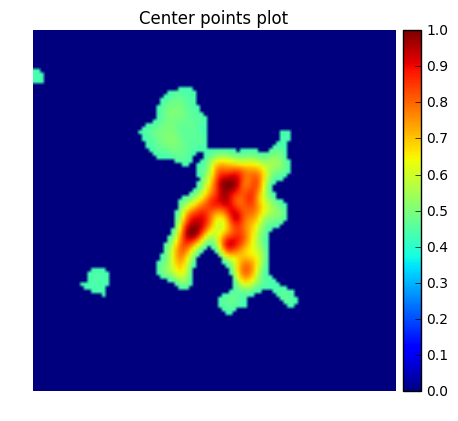

In [11]:
plt.figure(figsize=(5,5))
ax = plt.gca()
_data = np.zeros(data.shape)
mask = data > estimate_rms(data)
_data[mask] = data[mask]
im = ax.imshow(_data)
plt.title('Center points plot')
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.08)
plt.colorbar(im, cax=cax)
plt.show()

In [12]:
"""
Boundary points
"""
#number of boundary points by side
Nb = 0
Nc = 500
Ne = 2*Nc-4*Nb

xb = []
yb = []

for val in np.linspace(0., 1., Nb+1)[0:-1]:
    xb.append(val)
    yb.append(0.)
for val in np.linspace(0., 1., Nb+1)[0:-1]:
    xb.append(1.)
    yb.append(val)
for val in np.linspace(0., 1., Nb+1)[::-1][:-1]:
    xb.append(val)
    yb.append(1.)
for val in np.linspace(0., 1., Nb+1)[::-1][:-1]:
    xb.append(0.)
    yb.append(val)
xb = np.asarray(xb)
yb = np.asarray(yb)
boundary_points = np.vstack([xb,yb]).T

In [13]:
def accumulation_points_finder(x, y, data, n_ipoints=100, n_epoints=100, n_points=200,
                               method='weighted_kmeans', factor=1., split=True):
    #structuring the data
    X,Y = np.meshgrid(x, y, sparse=False)
    rms = estimate_rms(data)
    if split:
        
        mask = data > rms
        # extracting positions and values over the rms
        iX = X[mask]; iY = Y[mask]; idata = data[mask]
        # extracting positions and values above the rms
        eX = X[~mask]; eY = Y[~mask]; edata = data[~mask]
    else:
        X = X.ravel()
        Y = Y.ravel()
        data = data.ravel()

    if method=='weighted_kmeans':
        if split:
            """
            Clustering for points over the RMS
            """
            res = []
            for i in range(len(idata)):
                w = int(ceil((idata[i]/rms)**factor))
                res.extend([[iX[i],iY[i]]]*w)
            res = np.asarray(res)
            #kmeans object instantiation
            ikmeans = KMeans(init='k-means++', n_clusters=n_ipoints, n_init=15, n_jobs=2)
            #performing kmeans clustering
            ikmeans.fit(res)
            """
            Clustering for points above the RMS
            """
            res = []
            rms = estimate_rms(edata)
            for i in range(len(edata)):
                w = int(ceil((edata[i]/rms)**factor))
                res.extend([[eX[i],eY[i]]]*w)
            res = np.asarray(res)
            #kmeans object instantiation
            ekmeans = KMeans(init='k-means++', n_clusters=n_epoints, n_init=15, n_jobs=2)
            #performing kmeans clustering
            ekmeans.fit(res)
            """
            Concatenating and returning cetroid positions
            """
            return np.vstack([ikmeans.cluster_centers_[:,:2],ekmeans.cluster_centers_[:,:2]])
        
        else:
            """
            Clustering for all the points
            """
            res = []
            for i in range(len(data)):
                w = int(ceil((data[i]/rms)**factor))
                res.extend([[X[i],Y[i]]]*w)
            res = np.asarray(res)
            #kmeans object instantiation
            kmeans = KMeans(init='k-means++', n_clusters=n_points, n_init=15, n_jobs=2)
            #performing kmeans clustering
            kmeans.fit(res)
            return(kmeans.cluster_centers_[:,:2])
            

def points_plot(data, center_points=None, collocation_points=None, boundary_points=None):
    if (center_points is not None) and (collocation_points is None):
        plt.figure(figsize=(8,8))
        plt.imshow(data)
        plt.scatter(center_points[:,0]*99, center_points[:,1]*99, c='r', s=5, label='center')
        plt.title('Center points')
        plt.axis('off')
    elif (center_points is None) and (collocation_points is not None):
        plt.figure(figsize=(8,8))
        plt.imshow(data)
        plt.scatter(collocation_points[:,0]*99, collocation_points[:,1]*99, c='g', s=5, label='collocation')
        plt.title('Collocation points')
        plt.axis('off')
    elif (center_points is not None) and (collocation_points is not None):
        fig = plt.figure(figsize=(20,15))
        ax1 = fig.add_subplot(121)
        ax1.imshow(data)
        ax1.scatter(center_points[:,0]*99, center_points[:,1]*99, c='r', s=5, label='center')
        ax1.set_title('Center points')
        ax1.axis('off')
        ax2 = fig.add_subplot(122)
        ax2.imshow(data)
        ax2.scatter(collocation_points[:,0]*99, collocation_points[:,1]*99, c='g', s=5, label='collocation')
        ax2.set_title('Collocation points')
        ax2.axis('off')
    if (boundary_points is not None) and len(boundary_points[:,0])!=0:
        plt.figure(figsize=(8,8))
        plt.imshow(data)
        plt.scatter(boundary_points[:,0]*99, boundary_points[:,1]*99, c='y', s=5, label="boundary")
        plt.axis('off')
    #plt.colorbar(im, cax=cax)
    #fig.legend(bbox_to_anchor=(1.2, 1.0))
    plt.show()

### Accumulation points: Approach 1

In [14]:
class APoints():
    def __init__(self, n_points, dfunc):
        self.n_points = n_points
        self.dfunc = dfunc
    
    def F(self, points):
        points = points.reshape((self.n_points,2))
        D = np.empty(self.n_points)
        for i in range(self.n_points):
            dist = ((points[i] - points)**2).sum(axis=1)
            dist[dist==0.] = np.inf
            D[i] = dist.min()
        # this must be improved
        W = np.diagonal(self.dfunc(points[:,0], points[:,1]))
        return np.sum(-(1./W)**3 * D )

In [15]:
_xe = np.linspace(0., 1., 10)[1:-1]
_ye = np.linspace(0., 1., 10)[1:-1]
Xe,Ye = np.meshgrid(_xe, _ye, sparse=False)
xe = Xe.ravel(); ye = Ye.ravel()

In [16]:
center_points = np.hstack((xe.reshape(-1,1), ye.reshape(-1,1)))

In [17]:
ap = APoints(center_points.shape[0], f)

In [18]:
ap.F(center_points.ravel())

-10.703900006897914

In [19]:
sol = sp.optimize.minimize(ap.F, center_points.ravel(), method='L-BFGS-B', bounds=[(0.,1.)]*len(center_points.ravel()))
c_points = sol.x.reshape(center_points.shape)

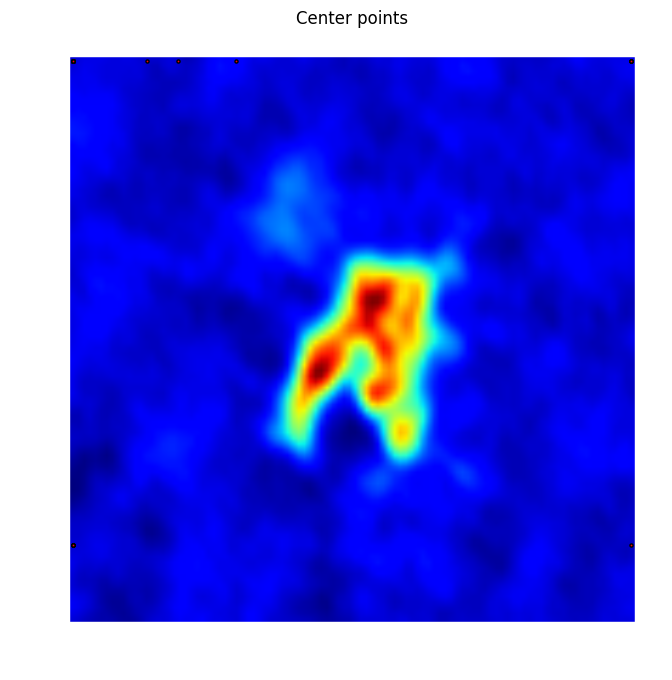

In [20]:
points_plot(data, center_points=c_points)

### Accumulation points: Approach 1.2

In [31]:
def cons_verification(points):
    n_points = len(points)/2
    points = points.reshape((n_points,2))
    D = np.empty(n_points)
    for i in range(n_points):
        dist = ((points[i] - points)**2).sum(axis=1)
        dist[dist==0.] = np.inf
        D[i] = dist.min()
    return np.abs(D[i] - 0.1)
    

class APoints2():
    def __init__(self, n_points, dfunc):
        self.n_points = n_points
        self.dfunc = dfunc
    
    def F(self, points):
        points = points.reshape((self.n_points,2))
        I = self.dfunc(points[:,0], points[:,1])
        return -np.sum(I)

In [27]:
ap = APoints2(center_points.shape[0], f)

In [28]:
ap.F(center_points.ravel())

-1754.1751918792725

In [29]:
cons = ({'type': 'ineq', 'fun': cons_verification})
bnds = [(0.,1.)]*len(center_points.ravel())
sol = sp.optimize.minimize(ap.F, center_points.ravel(), method='SLSQP', bounds=bnds, constraints=cons)
c_points = sol.x.reshape(center_points.shape)

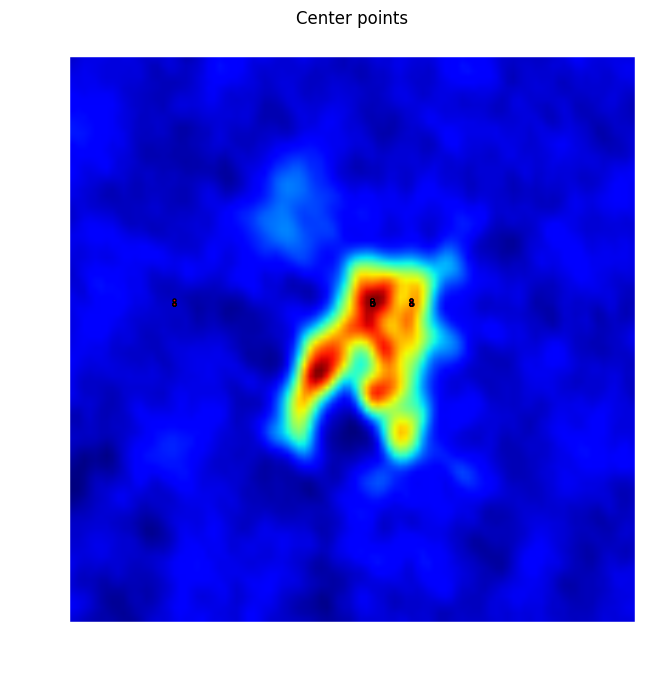

In [30]:
points_plot(data, center_points=c_points)

### Approach 1.3

In [105]:
def R(x):
    ret = np.empty(x.shape)
    mask0 = x<2.
    mask1 = x>=2.
    ret[mask0] = np.cos(np.pi/2 * x[mask0])
    ret[mask1] = -2 / (1. + np.exp((x[mask1]-2)**2))
    return ret

def d(x, sigmin=0.05, sigmax=0.25):
    alpha = -np.log(sigmin/sigmax)
    return sigmax * np.exp(-alpha * x)
    

class APoints3():
    def __init__(self, n_points, dfunc, eps=1e-10):
        self.n_points = n_points
        self.dfunc = dfunc
        self.eps = 1e-10
  
    def F(self, points, t=0.):
        points = points.reshape((self.n_points,2))
        # distance matrices
        Dx = np.empty((self.n_points, self.n_points))
        Dy = np.empty((self.n_points, self.n_points))
        for i in range(points.shape[0]):
            Dx[i] = points[:,0] - points[i,0] 
            Dy[i] = points[:,1] - points[i,1]
        D = np.sqrt(Dx**2 + Dy**2) + self.eps
        # intensities at each point
        I = np.diagonal(self.dfunc(points[:,0], points[:,1]))
        # computing derivatives
        tmp = R(D / d(I))
        tmp /= D
        dX = (Dx * tmp).sum(axis=1)
        dY = (Dy * tmp).sum(axis=1)
        ret = np.vstack([dX,dY]).T
        return ret.ravel()

$$
R(x) = \begin{cases} 
      \cos(\frac{\pi}{2} x) &  0 \leq x < 2 \\
      \frac{-2}{1 + e^{(x-2)^2}} & 2 \leq x
\end{cases}
$$

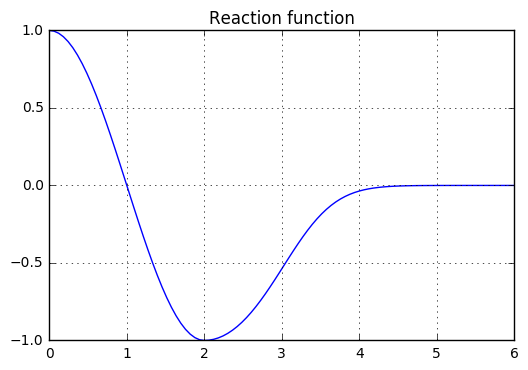

In [86]:
xgrid = np.linspace(0., 6., 100)
plt.plot(xgrid, R(xgrid))
plt.title('Reaction function')
plt.grid()
plt.show()

**Note**: Remember that the intensity values are bounded in the $[0,1]$ interval.

$$
d(I) = \sigma_{\text{max}} e^{-\alpha x} \ \ \ \ \ \text{with} \ \ \ \ \alpha = - \ln \left(\frac{\sigma_{\text{min}}}{\sigma_{\text{max}}}\right)
$$

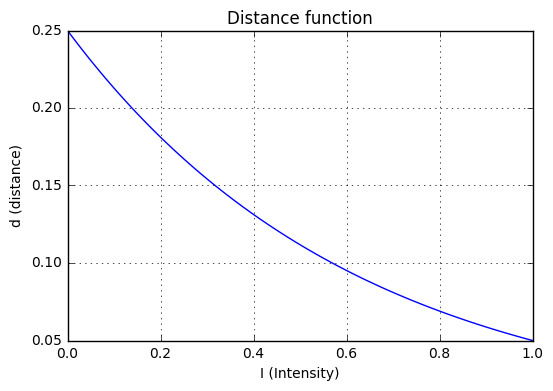

In [87]:
xgrid = np.linspace(0., 1., 100)
plt.plot(xgrid, d(xgrid))
plt.title('Distance function')
plt.xlabel('I (Intensity)')
plt.ylabel('d (distance)')
plt.grid()
plt.show()

#### Testing of approach 1.3

In [116]:
_xe = np.linspace(0., 1., 10)[1:-1]
_ye = np.linspace(0., 1., 10)[1:-1]
Xe,Ye = np.meshgrid(_xe, _ye, sparse=False)
xe = Xe.ravel(); ye = Ye.ravel()
center_points = np.hstack((xe.reshape(-1,1), ye.reshape(-1,1)))

In [117]:
ap = APoints3(center_points.shape[0], f)

In [112]:
%timeit ap.F(center_points.flatten())

The slowest run took 11.79 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 455 µs per loop


In [118]:
time_grid = np.linspace(0., 2., 100)
sol = sp.integrate.odeint(ap.F, center_points.flatten(), time_grid)

In [122]:
sol[-1]

array([  7.74860416e-304,   3.25060610e-319,   7.74859720e-304,
         2.13031734e-314,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   7.29112202e-304,
         2.13031734e-314,   0.00000000e+000,   7.74860419e-304,
         0.00000000e+000,   7.74860419e-304,   1.26974871e-321,
         0.00000000e+000,   0.00000000e+

In [124]:
sol[-1].reshape(center_points.shape)

array([[  7.74860416e-304,   3.25060610e-319],
       [  7.74859720e-304,   2.13031734e-314],
       [  0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000],
       [  7.29112202e-304,   2.13031734e-314],
       [  0.00000000e+000,   7.74860419e-304],
       [  0.0

### Accumulation points: Approach 2

In [92]:
def update_neighbors(pp, ps, length, bounds):
    """
    pp - current pixel position.
    ps - pixel set to be updated
    length - length of the neighborhood
    bounds - boundary indexes of the data
    """
    for i in range(-length, length+1):
        for j in range(-length, length+1):
            if i==j==0: continue
            # neighbor position
            np = (pp[0]+i, pp[0]+j)
            # out of range conditions
            out1 = np[0]<0 or np[1]<0 
            out2 = np[0]>bounds[0] or np[1]>bounds[1]
            if out1 or out2: continue
            # remove neighbor from pixel set
            if np in ps: ps.remove(np)

def acc_points_finder(data, n_level):
    bounds = data.shape
    dmin = data.min()
    dmax = data.max()
    intensity_range = np.linspace(dmin, dmax, n_level)
    # list of selected pixels
    selected = []
    # initial neighborhood length
    length = 3
    
    for level in range(n_level-1, 0, -1):
        mask = np.logical_and(data > intensity_range[level-1], data <= intensity_range[level])
        print("Data between {0} and {1}".format(intensity_range[level], intensity_range[level-1]))
        # pixel positions and pixel set generation
        pp = np.where(mask)
        ps = []
        for i in range(len(pp[0])):
            ps.append((pp[0][i], pp[1][i]))
        print('length of ps: {0}'.format(len(ps)))
        
        # while pixel set is not empty
        while(ps):
            # find the pixel with higher intensity
            pmax = None
            pmax_val = -np.inf
            for pix in ps:
                if data[pix] > pmax_val:
                    pmax = pix
                    pmax_val = data[pix]
            
            # append it to selected pixels
            selected.append(pmax)
            # remove it from the pixel set
            ps.remove(pmax)
            # remove also his neighbors
            update_neighbors(pmax, ps, length, bounds)
        # update the length
        length += 10
    return selected

In [93]:
center_pixels = acc_points_finder(data, 3)

Data between 1.0 and 0.670730054379
length of ps: 435
Data between 0.670730054379 and 0.341460108757
length of ps: 9564


In [94]:
center_points_ = np.empty((len(center_pixels), 2))
for i,pp in enumerate(center_pixels):
    center_points_[i,0] = pp[0]+0.5
    center_points_[i,1] = pp[1]+0.5
center_points_ /= 100.

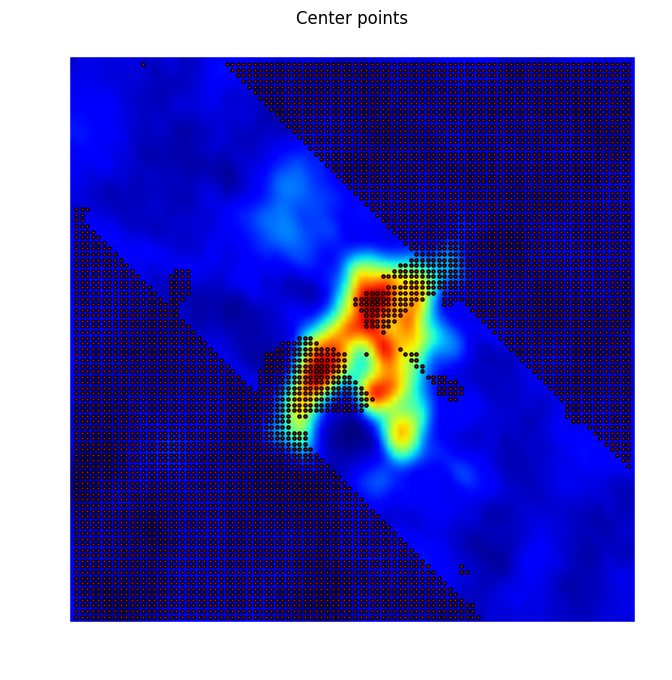

In [96]:
points_plot(data, center_points=center_points_)

### Extra (evaluation/collocation) points

In [29]:
center_points = accumulation_points_finder(x, y, data, n_ipoints=Nc/2, n_epoints=Nc/2, factor=5., split=True)
extra_points = accumulation_points_finder(x, y, np.exp(1.-data), n_points=Nc, factor=1., split=False)

In [30]:
class EPoints():
    def __init__(self, center_points):
        self.center_points = center_points
    
    def F(self, extra_points):
        extra_points = extra_points.reshape(self.center_points.shape)
        points = np.vstack((self.center_points, extra_points))
        N = points.shape[0]
        D = np.empty(N/2)
        for i in range(N/2):
            dist = ((extra_points[i] - points)**2).sum(axis=1)
            dist[dist==0.] = np.inf
            D[i] = dist.min()
        return 1./np.sum(D)

In [31]:
ep = EPoints(extra_points)
ep.F(extra_points)

1.1843653655929893

In [32]:
sol = sp.optimize.minimize(ep.F, extra_points.ravel(), method='L-BFGS-B', bounds=[(0.,1.)]*len(extra_points.ravel()))
extra_points = sol.x.reshape(extra_points.shape)

**Note:** In order to verify that there are no overlaping points between `center_points` and `extra_points`, we compute the *minimal distance*. To verify that these set of points are different, we compute the Hausdorff distance between them.

In [33]:
Dx = np.empty((Nc,Nc))
Dy = np.empty((Nc,Nc))
for k in range(Nc):
    Dx[k,:] = center_points[k,0]-extra_points[:,0]
    Dy[k,:] = center_points[k,1]-extra_points[:,1]
dist_matrix = np.sqrt(Dx**2+Dy**2)
    
print('Minimal distance: {0}'.format(dist_matrix.min()))
print('Hausdorff distance: {0}'.format(cm.hausdorff(center_points, extra_points)))

Minimal distance: 0.00117978653432
Hausdorff distance: 0.0404802515915


### Visualization of points

In [34]:
collocation_points = np.vstack((center_points, extra_points))

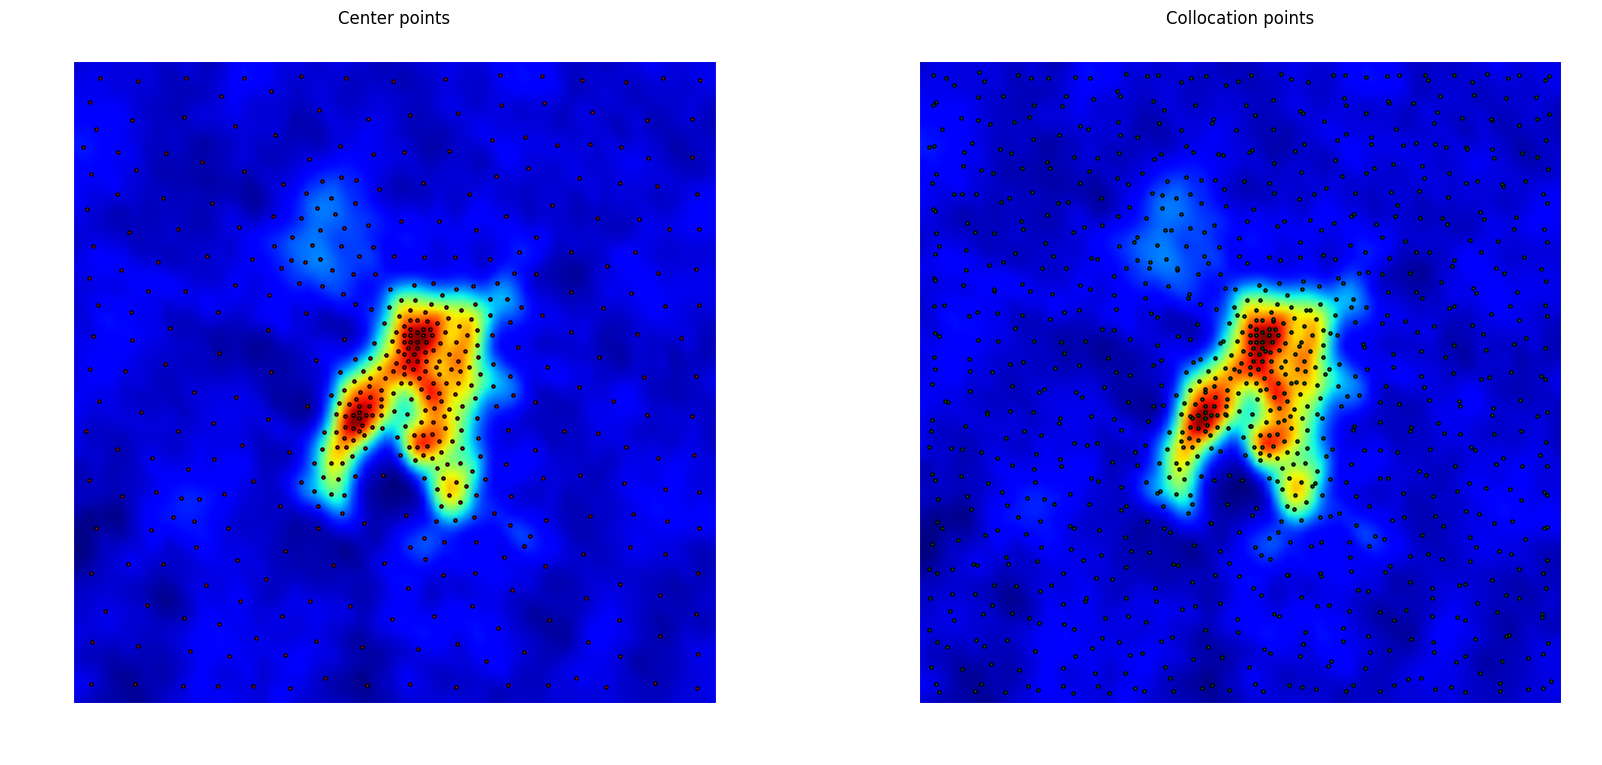

In [35]:
points_plot(data, center_points=center_points, collocation_points=collocation_points)

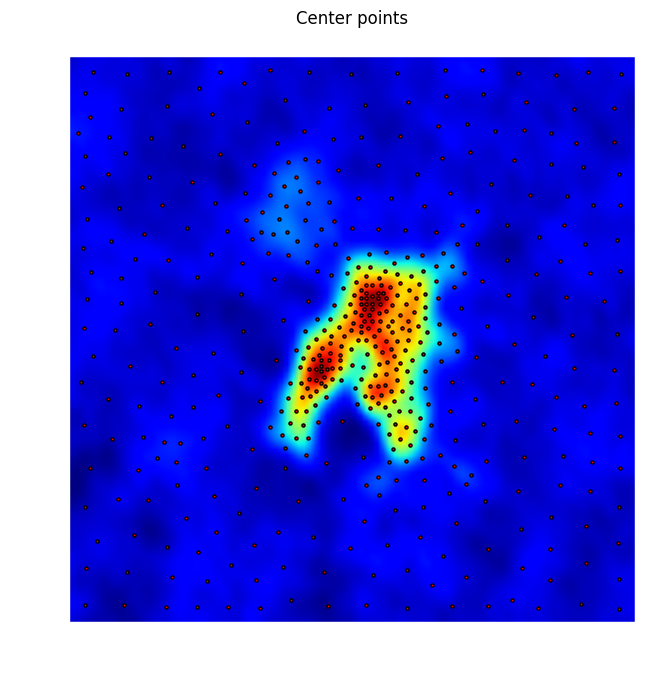

In [36]:
points_plot(data, center_points=center_points)

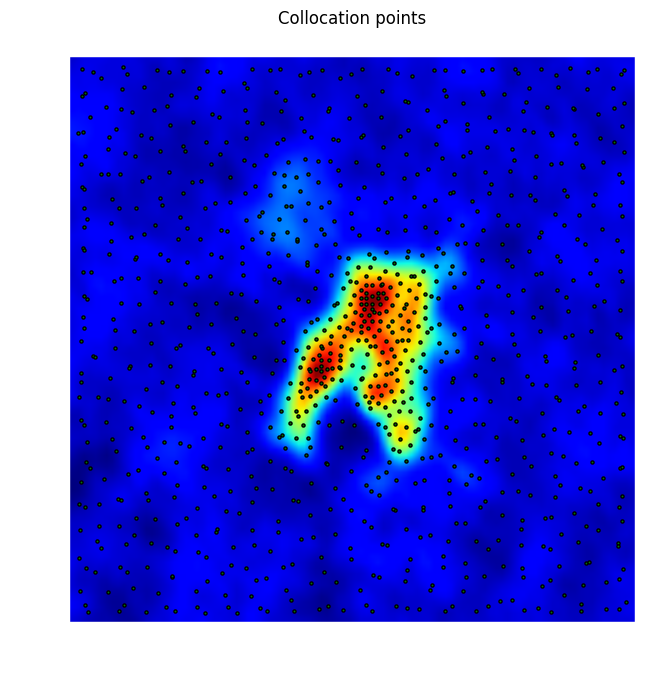

In [37]:
points_plot(data, collocation_points=collocation_points)

In [38]:
points_plot(data, boundary_points=boundary_points)

In [39]:
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]

## Initial Conditions

In [40]:
"""
Building distances matrix
"""
Nc = center_points.shape[0]
Dx = np.empty((Nc,Nc))
Dy = np.empty((Nc,Nc))
for k in range(Nc):
    Dx[k,:] = xc[k]-xc
    Dy[k,:] = yc[k]-yc
dist_matrix = np.sqrt(Dx**2+Dy**2)

In [41]:
def estimate_initial_guess(center_points, dist_matrix, dfunc, R=0.05, minsig=0.001, method='min_dist'):
    m = center_points.shape[0]
    c_arr = np.empty(m, dtype=float)
    sig_arr = np.empty(m, dtype=float)
    
    if method=='mean_dist':
        f = 1./sqrt(log(2.))
        mean_dist = np.zeros(m, dtype=float)
        num_neigh = np.zeros(m, dtype=float)   
        for i in range(m):
            for j in range(m):
                #dont take into account the same point
                if i==j: continue
                d = dist_matrix[i,j]
                #dont take into account points outside R radius
                if d>R: continue
                num_neigh[i] += 1
                mean_dist[i] += d
            """
            Key Idea: The mean distance to neighbors acurrs when the
            gaussian function has decayed to the half
            """
            if num_neigh[i]==0:
                c_arr[i] = dfunc(*center_points[i])[0]
                sig_arr[i] = minsig
            else:
                mean_dist[i] /= num_neigh[i]
                c_arr[i] = dfunc(*center_points[i])[0]/num_neigh[i]
                #c_arr[i] = dfunc(*center_points[i])[0]*mean_dist[i]**2
                sig_arr[i] = f*mean_dist[i]
                
    elif method=='min_dist':
        min_dist = np.inf*np.ones(m, dtype=float)
        num_neigh = np.zeros(m, dtype=float)
        #first we find the distance to the nearest neighbor
        for i in range(m):
            for j in range(m):
                #dont take into account the same point
                if i==j: continue
                d = dist_matrix[i,j]
                if d<min_dist[i]: min_dist[i] = d
        #second, we find the number of neighbors on the neighborhood
        for i in range(m):
            for j in range(m):
                #dont take into account the same point
                if i==j: continue
                d = dist_matrix[i,j]
                if d > 3*min_dist[i]: continue
                num_neigh[i] += 1
            """
            some explanation here
            """
            if num_neigh[i]==0:
                c_arr[i] = dfunc(*center_points[i])[0]
                sig_arr[i] = minsig
            else:
                c_arr[i] = dfunc(*center_points[i])[0]/(num_neigh[i]+1)
                sig_arr[i] = min_dist[i] 
    return (c_arr,sig_arr)

In [42]:
"""
Initial parameters estimation
"""
#c0, sig0 = estimate_initial_guess(center_points, f, R=0.009, method='mean_dist')
c0, sig0 = estimate_initial_guess(center_points, dist_matrix, f, minsig=minsig, method='min_dist')

## Visualizing the initial solution

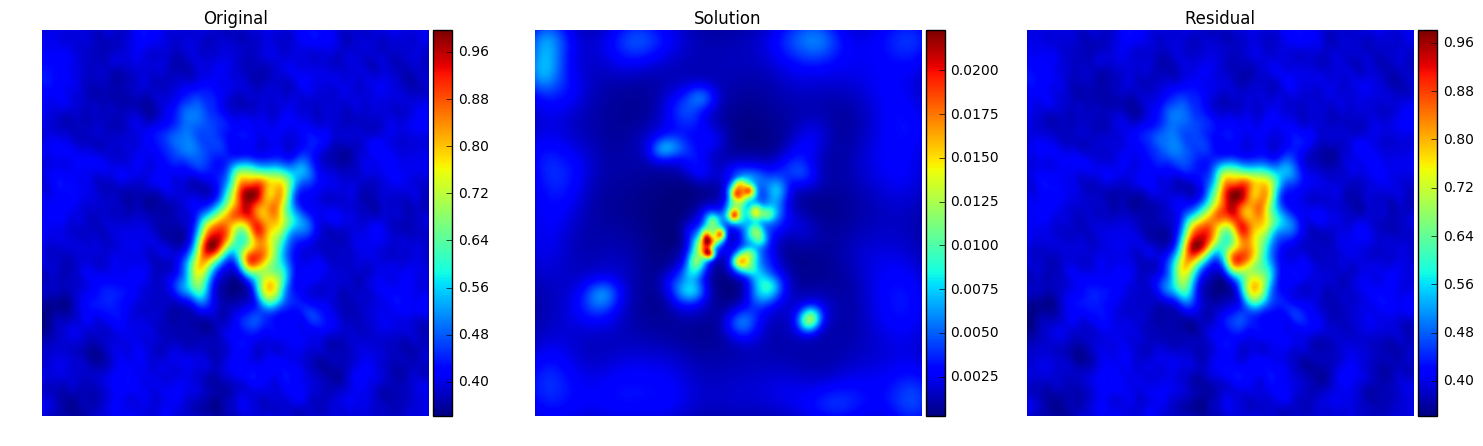

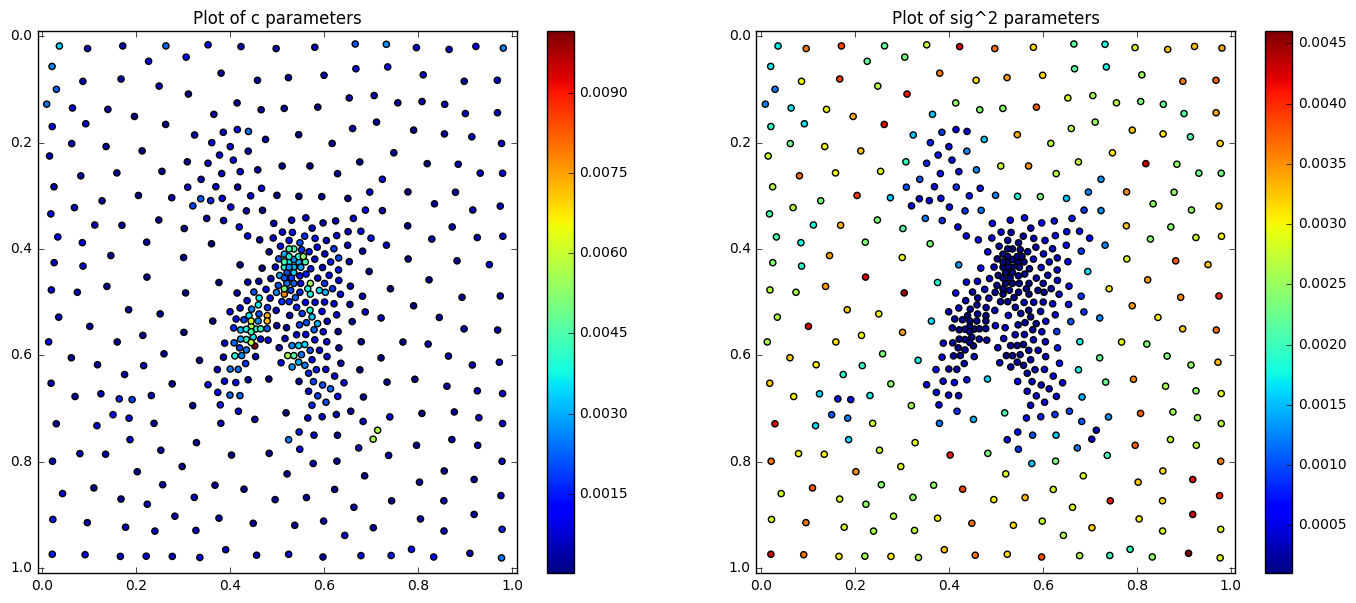

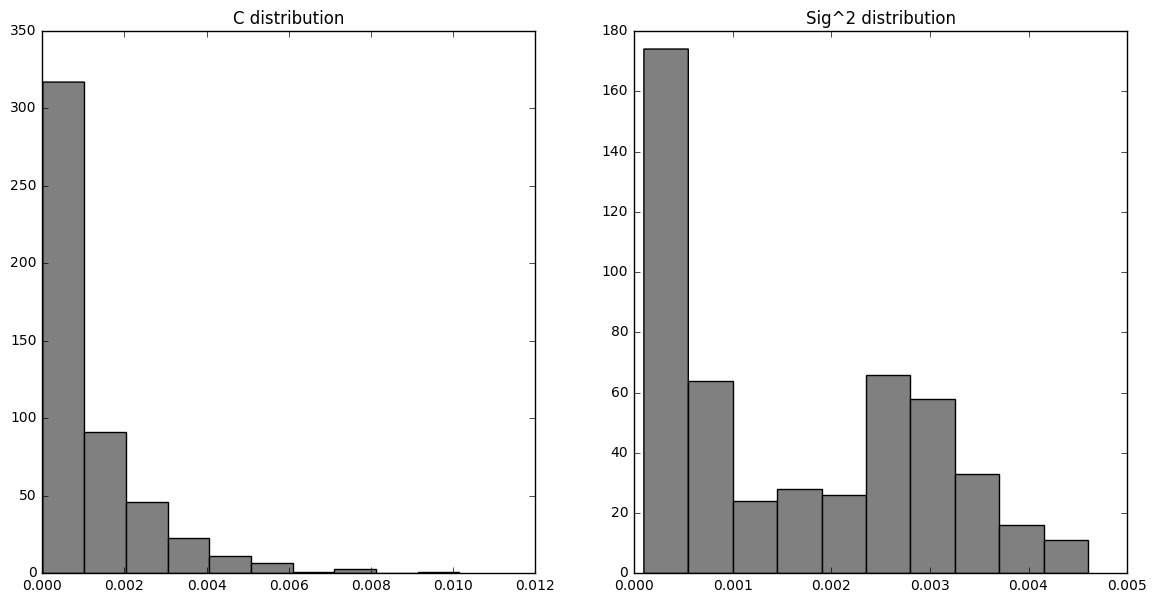

In [43]:
#plot_sol(c0, sig0, xc, yc, base_level=estimate_rms(data))
plot_sol(c0, sig0, xc, yc, base_level=0., compact_supp=False)
params_plot(c0, sig0, xc, yc, square_c=True)
params_distribution_plot(c0, sig0, square_c=True)

# Experiments

In [53]:
def el_solver(elf, method='iterative', n_iter=5, verbose=True, base_level=0., 
              square_c=True, compact_supp=False, step_iter=2000, max_iter=20000):
#     if method=='exact':
#         sol = sp.optimize.root(elf.F, np.concatenate([elf.c, elf.sig]), method='lm', options={'maxiter':2000})
#         opt_c = sol.x[0:Nc]
#         opt_sig = sol.x[Nc:]
#         delta_c = np.linalg.norm(opt_c-elf.c)
#         delta_sig = np.linalg.norm(opt_sig-elf.sig)
#         var,entr,rms = plot_sol(opt_c, opt_sig, elf.xc, elf.yc, base_level=base_level, 
#                  square_c=square_c, compact_supp=compact_supp)
#         params_plot(elf.c, elf.sig, elf.xc, elf.yc, square_c=square_c)
#         params_distribution_plot(elf.c, elf.sig, square_c=square_c)
#         print('Variation on c={0}'.format(delta_c))
#         print('Variation on sig={0}'.format(delta_sig))
#         print('\nsuccess: {0}'.format(sol['success']))
#         print('\nstatus: {0}'.format(sol['status']))
#         print('\nmessage: {0}'.format(sol['message']))
#         #print('\nopt_c_squared:\n {0}'.format(opt_c**2))
#         #print('\nopt_sig:\n {0}'.format(opt_sig))
#         print('-------------------------------------------------------------------')
        
    if method=='exact':
        residual_variance = []
        residual_entropy = []
        residual_rms = []
        iter_list = range(step_iter, max_iter+1, step_iter)
        
        for it in iter_list:
            print('\n'+'#'*120)
            print('Results after {0} iterations'.format(it))
            print('#'*120)
            # lm optimization
            sol = sp.optimize.root(elf.F, np.concatenate([elf.c, elf.sig]), method='lm', options={'maxiter':step_iter})
            opt_c = sol.x[0:Nc]
            opt_sig = sol.x[Nc:]
            
            # variation of c and sig
            delta_c = np.linalg.norm(opt_c-elf.c)
            delta_sig = np.linalg.norm(opt_sig-elf.sig)
            
            # update of best parameters
            elf.set_c(opt_c)
            elf.set_sig(opt_sig)
            
            # residual stats
            var,entr,rms = compute_residual_stats(opt_c, opt_sig, elf.xc, elf.yc, base_level=base_level, 
                     square_c=square_c, compact_supp=compact_supp)
            
            # setting the new current solution
            elf.set_c(opt_c)
            elf.set_sig(opt_sig)
            
            #appending residual variance, entropy and rms
            residual_variance.append(var)
            residual_entropy.append(entr)
            residual_rms.append(rms)
            
            print('Variation on c = {0}'.format(delta_c))
            print('variation on sig = {0}'.format(delta_sig))
            print('\nsuccess: {0}'.format(sol['success']))
            print('\nstatus: {0}'.format(sol['status']))
            print('\nmessage: {0}'.format(sol['message']))
            print('\nnfev: {0}'.format(sol['nfev']))
            if sol['success']: break
        
        print('\n \n' + '#'*120)    
        print('FINAL RESULTS:')
        print('#'*120)
        
        # plots generation
        plot_sol(opt_c, opt_sig, elf.xc, elf.yc, base_level=base_level, 
                 square_c=square_c, compact_supp=compact_supp)
        params_plot(elf.c, elf.sig, elf.xc, elf.yc, square_c=square_c)
        params_distribution_plot(elf.c, elf.sig, square_c=square_c)
        residual_plot(residual_variance, residual_entropy, residual_rms, iter_list[0:len(residual_rms)])
    
    if method=='mixed':
        print('\n'+'#'*120)
        print('Iteration: 0  -  Optimization on both c and sig parameters')
        print('#'*120)
        sol = sp.optimize.root(elf.F, np.concatenate([elf.c, elf.sig]), method='lm', options={'maxiter':10000}, callback=calllback)
        opt_c = sol.x[0:Nc]
        opt_sig = sol.x[Nc:]
        delta_c = np.linalg.norm(opt_c-elf.c)
        delta_sig = np.linalg.norm(opt_sig-elf.sig)
        elf.set_c(opt_c)
        elf.set_sig(opt_sig)
        var,entr,rms = plot_sol(elf.c, elf.sig, elf.xc, elf.yc, base_level=base_level, 
                            square_c=square_c, compact_supp=compact_supp)
        params_plot(elf.c, elf.sig, elf.xc, elf.yc, square_c=square_c)
        params_distribution_plot(elf.c, elf.sig, square_c=square_c)

        print('Variation on c={0}'.format(delta_c))
        print('Variation on sig={0}'.format(delta_sig))
        print('\nmessage: {0}'.format(sol['message']))
        print('\nsuccess: {0}'.format(sol['success']))
    
    if method=='iterative' or method=='mixed':
        residual_variance = []
        residual_entropy = []
        residual_rms = []
        
        #print('\n'+'#'*120)
        #print('Initial Guess')
        #print('#'*120)
        #var,entr,rms = plot_sol(elf.c, elf.sig, elf.xc, elf.yc, base_level=base_level, square_c=square_c)
        #params_plot(elf.c, elf.sig, elf.xc, elf.yc, square_c=square_c)
        #params_distribution_plot(elf.c, elf.sig, square_c=square_c)
        #residual_variance.append(var)
        #residual_entropy.append(entr)
        #residual_rms.append(rms)
        
        for it in range(n_iter):
            print('\n'+'#'*120)
            print('Iteration: {0}  -  Optimization on c parameter'.format(it))
            print('#'*120)
            #solve for c
            sol = sp.optimize.root(elf.F1, elf.c, method='lm', options={'maxiter':10000})
            opt_c = sol.x
            delta_c = np.linalg.norm(opt_c-elf.c)
            elf.set_c(opt_c)
            #title = 'Best solution at iter={0} and improved c'.format(i)
            var,entr,rms = plot_sol(elf.c, elf.sig, elf.xc, elf.yc, base_level=base_level, 
                                    square_c=square_c, compact_supp=compact_supp)
            params_plot(elf.c, elf.sig, elf.xc, elf.yc, square_c=square_c)
            params_distribution_plot(elf.c, elf.sig, square_c=square_c)
            print('Variation on c={0}'.format(delta_c))
            print('\nnfev: {0}'.format(sol['nfev']))
            print('\nmessage: {0}'.format(sol['message']))
            print('\nsuccess: {0}'.format(sol['success']))
            if square_c:
                print('\nmax c and position: {0} and {1}'.format(np.max(opt_c**2), np.argmax(opt_c**2)))
            else:
                print('\nmax c and position: {0} and {1}'.format(np.max(opt_c), np.argmax(opt_c)))  
            
            #appending residual variance and entropy
            residual_variance.append(var)
            residual_entropy.append(entr)
            residual_rms.append(rms)

            print('\n'+'#'*120)
            print('Iteration: {0}  -  Optimization on sig parameter'.format(it))
            print('#'*120)
            #solve for sig
            sol = sp.optimize.root(elf.F2, elf.sig, method='lm', options={'maxiter':10000})
            opt_sig = sol.x
            delta_sig = np.linalg.norm(opt_sig-elf.sig)
            elf.set_sig(opt_sig)
            #title = 'Best solution at iter={0} and improved sig'.format(i)
            var,entr,rms = plot_sol(elf.c, elf.sig, elf.xc, elf.yc, base_level=base_level, 
                                    square_c=square_c, compact_supp=compact_supp)
            params_plot(elf.c, elf.sig, elf.xc, elf.yc, square_c=square_c)
            params_distribution_plot(elf.c, elf.sig, square_c=square_c)
            
            print('Variation on sig={0}'.format(delta_sig))
            print('\nnfev: {0}'.format(sol['nfev']))
            print('\nmessage: {0}'.format(sol['message']))
            print('\nsuccess: {0}'.format(sol['success']))
            print('\nmax sig and position: {0} and {1}'.format(np.max(opt_sig**2), np.argmax(opt_sig**2)))
            print('\nmin sig and position: {0} and {1}'.format(np.min(opt_sig**2), np.argmin(opt_sig**2)))
            print('-------------------------------------------------------------')
            #appending residual variance and entropy
            residual_variance.append(var)
            residual_entropy.append(entr)
            residual_rms.append(rms)

        print('\n \n' + '#'*120)    
        print('SOME FINAL RESULTS:')
        print('#'*120)
        plt.figure(figsize=(12,5))
        plt.subplot(1,3,1)
        plt.xlim(-0.2, (2.*n_iter-1)+0.2)
        plt.plot(range(2*n_iter), residual_rms, 'go-')
        plt.title('Residual RMS')        
        plt.subplot(1,3,2)
        plt.xlim(-0.2, (2.*n_iter-1)+0.2)
        plt.plot(range(2*n_iter), residual_variance, 'bo-')
        plt.title('Residual variance')
        plt.subplot(1,3,3)
        plt.xlim(-0.2, (2.*n_iter-1)+0.2)[]
        plt.plot(range(2*n_iter), residual_entropy, 'ro-')
        plt.title('Residual entropy')
        plt.show()

## Experiments 1: With  `base_level=0`
The following instances test with different settings combinations for: square_c and support

In [46]:
"""
ELFunc instantiations
"""

elf01 = ELFunc(f, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=1., lamb1=1., d1psi1=d1psi, d1psi2=d1psi,
              d2psi2=d2psi, base_level=0., square_c=True, compact_supp=False)


elf02 = ELFunc(f, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, d1psi2=d1psi,
              d2psi2=d2psi, base_level=0., square_c=False, compact_supp=False)

### C-squared and no compact support


########################################################################################################################
Results after 2000 iterations
########################################################################################################################
Variation on c = 0.75057622098
variation on sig = 0.570804134217

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

########################################################################################################################
Results after 4000 iterations
########################################################################################################################
Variation on c = 0.69792300196
variation on sig = 0.491110111982

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

###################################################################################################################

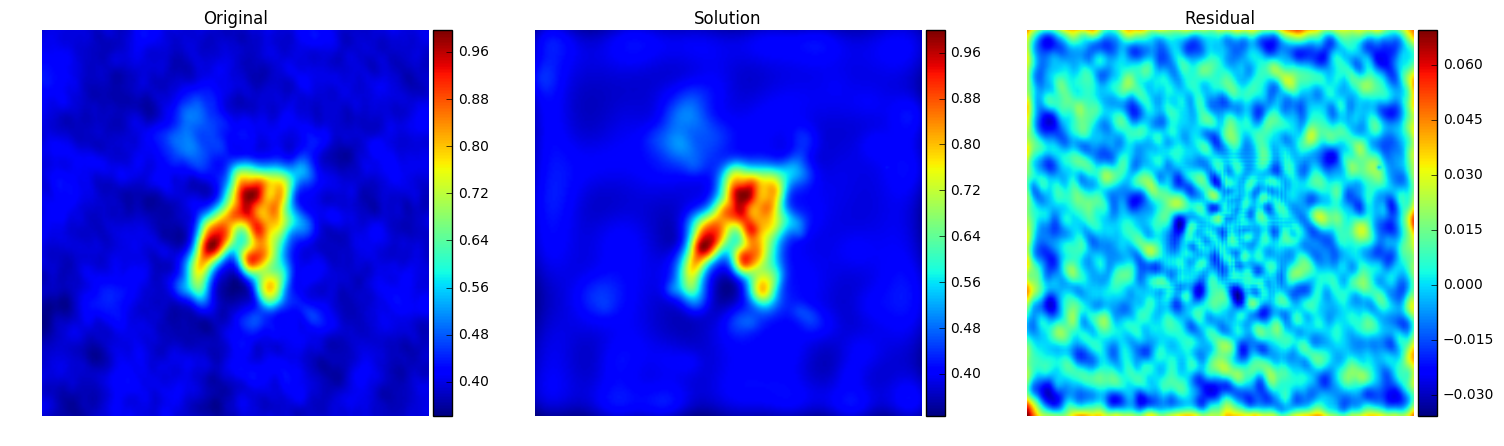

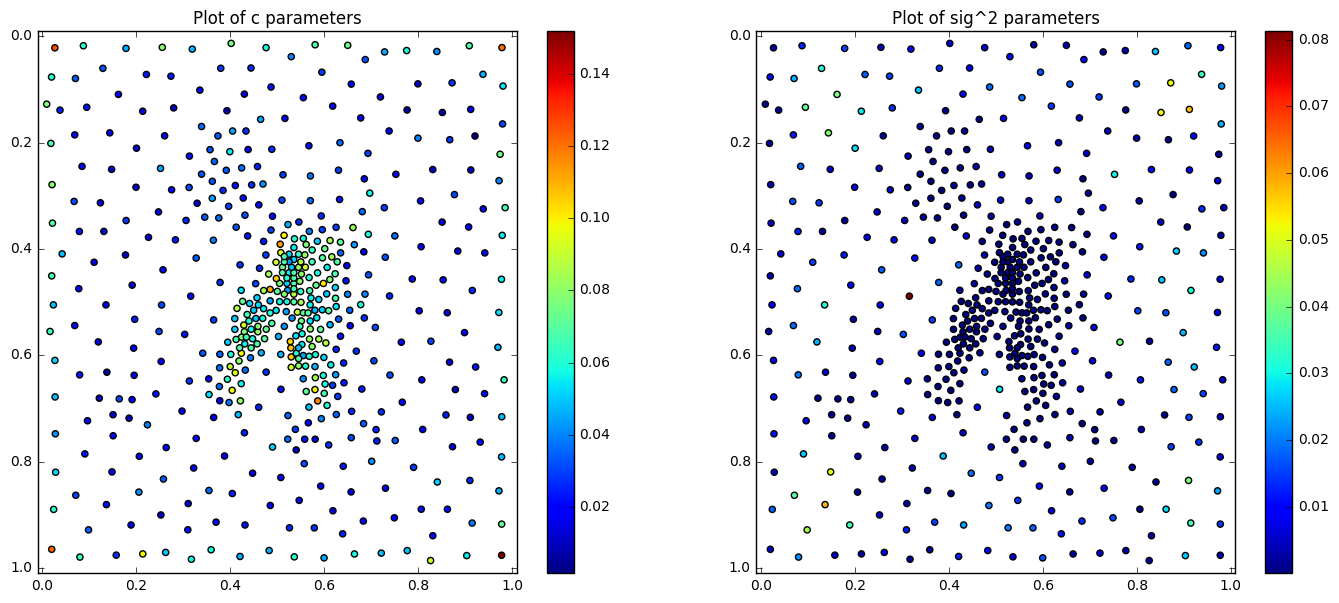

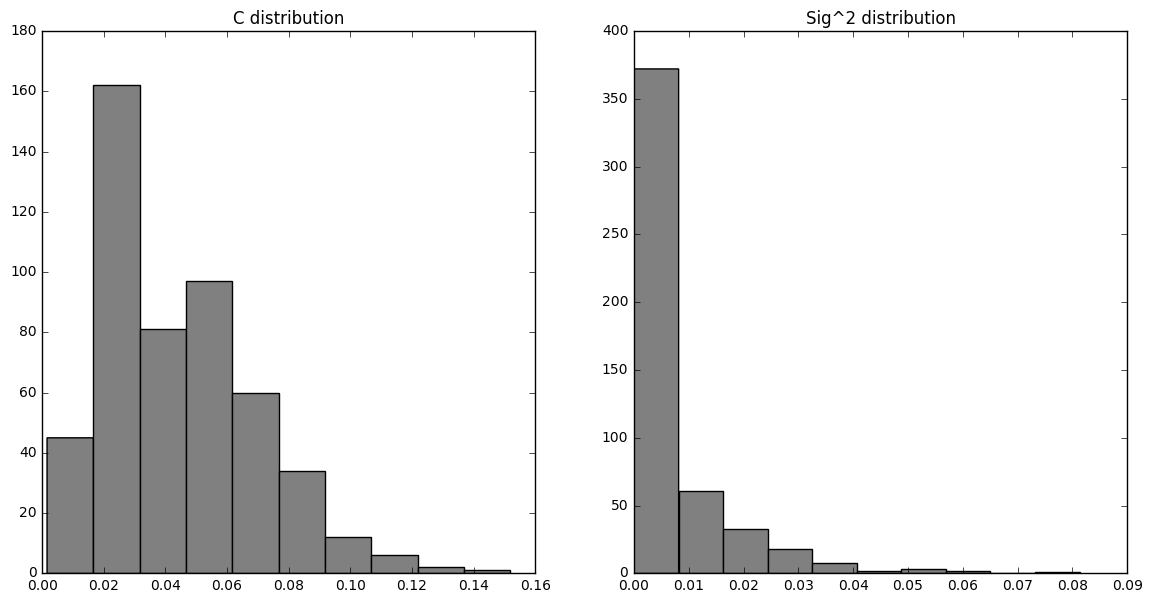

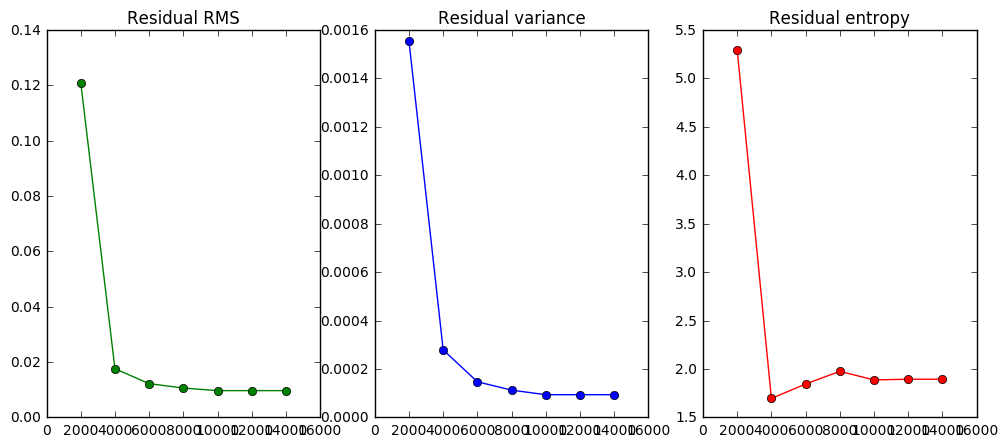

In [42]:
el_solver(elf01, method='exact', base_level=0., square_c=True, step_iter=2000, max_iter=50000)

### C-not squared and no compact support


########################################################################################################################
Results after 2000 iterations
########################################################################################################################
Variation on c = 0.19441547884
variation on sig = 0.441820772039

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

########################################################################################################################
Results after 4000 iterations
########################################################################################################################
Variation on c = 0.243135848877
variation on sig = 0.434090799827

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

##################################################################################################################

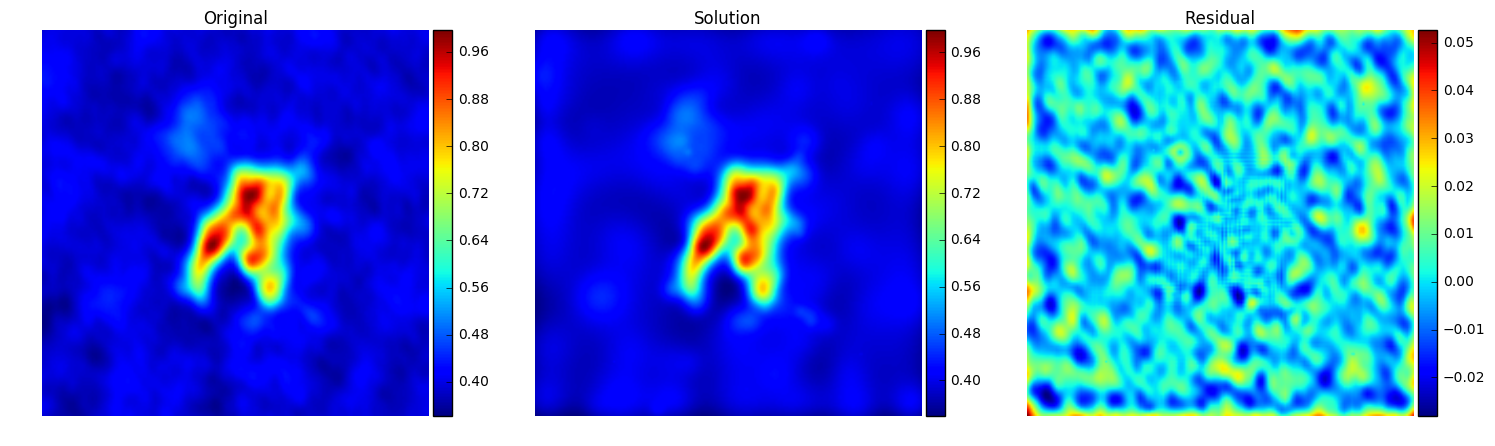

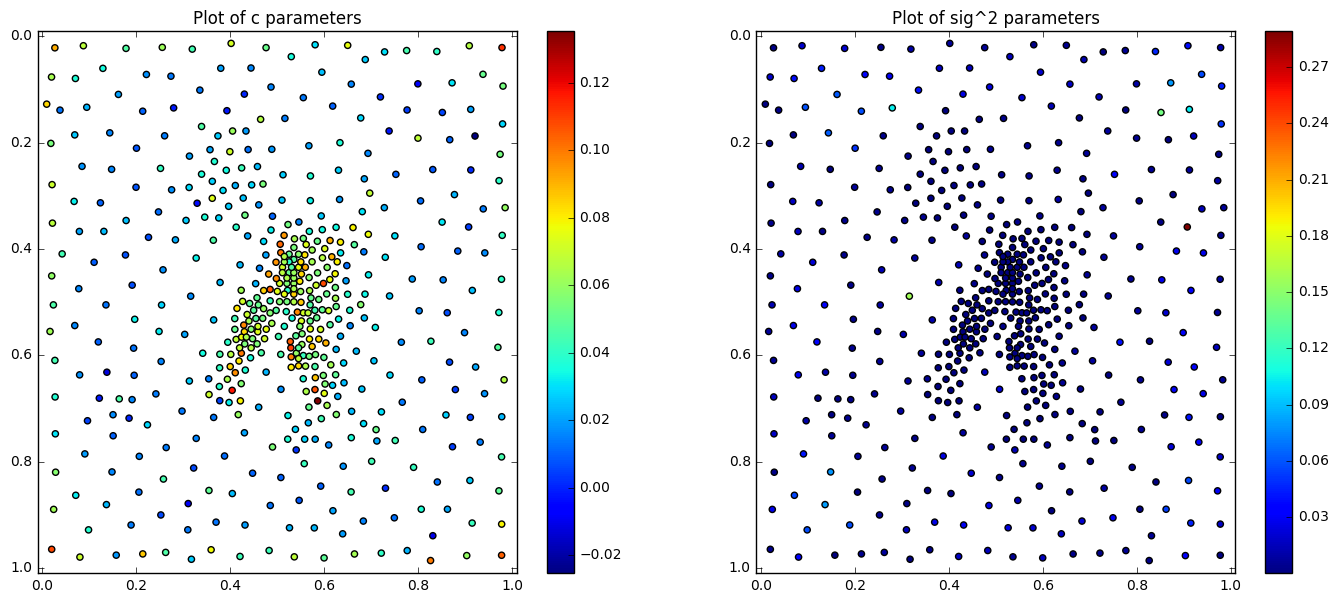

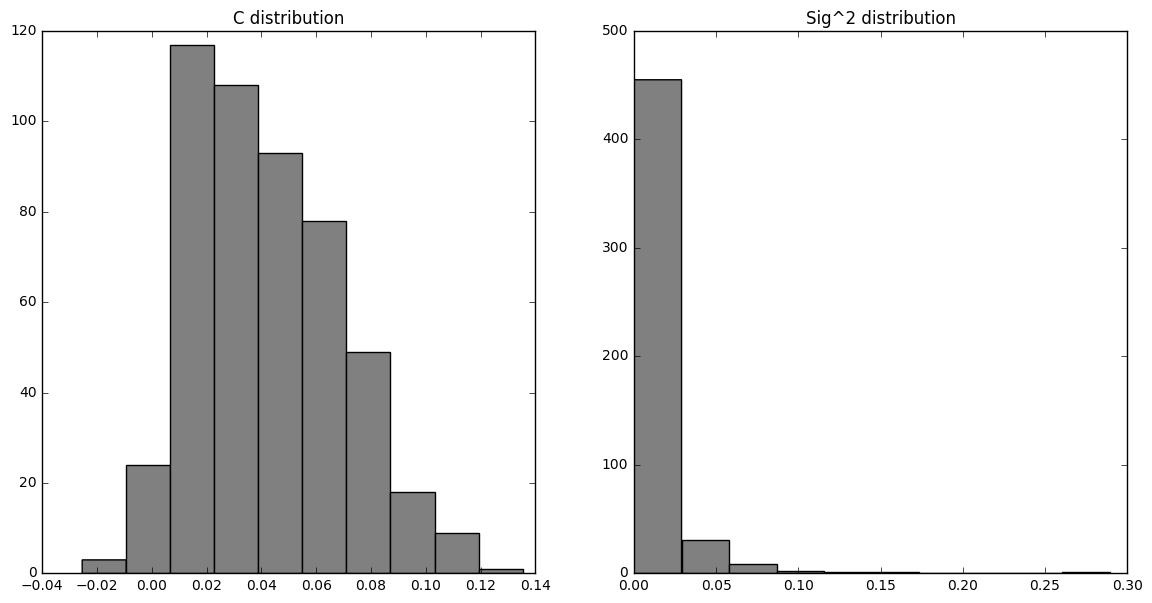

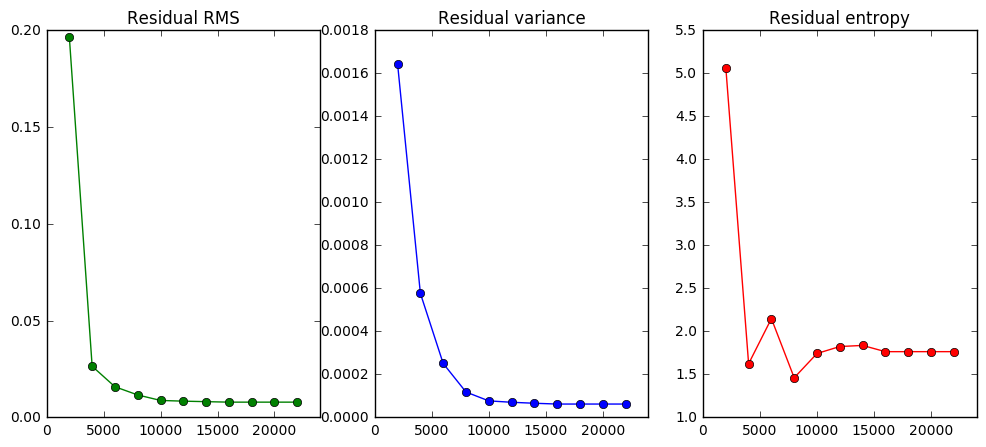

In [43]:
el_solver(elf02, method='exact', base_level=0., square_c=False, step_iter=2000, max_iter=50000)

# Adding the smoothing effect

In [51]:
"""
ELFunc instantiations
"""

elf03 = ELFunc(f, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=1., lamb1=1., b=0.001, lamb2=1., 
               d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=0., square_c=True, compact_supp=False)


elf04 = ELFunc(f, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=1., lamb1=1., b=0.0001, lamb2=1.,
               d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=0., square_c=True, compact_supp=False)


########################################################################################################################
Results after 2000 iterations
########################################################################################################################
Variation on c = 1.05287070911
variation on sig = 0.191236792574

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2008

########################################################################################################################
Results after 4000 iterations
########################################################################################################################
Variation on c = 1.03960516929
variation on sig = 0.345787764006

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2007

###################################################################################################################

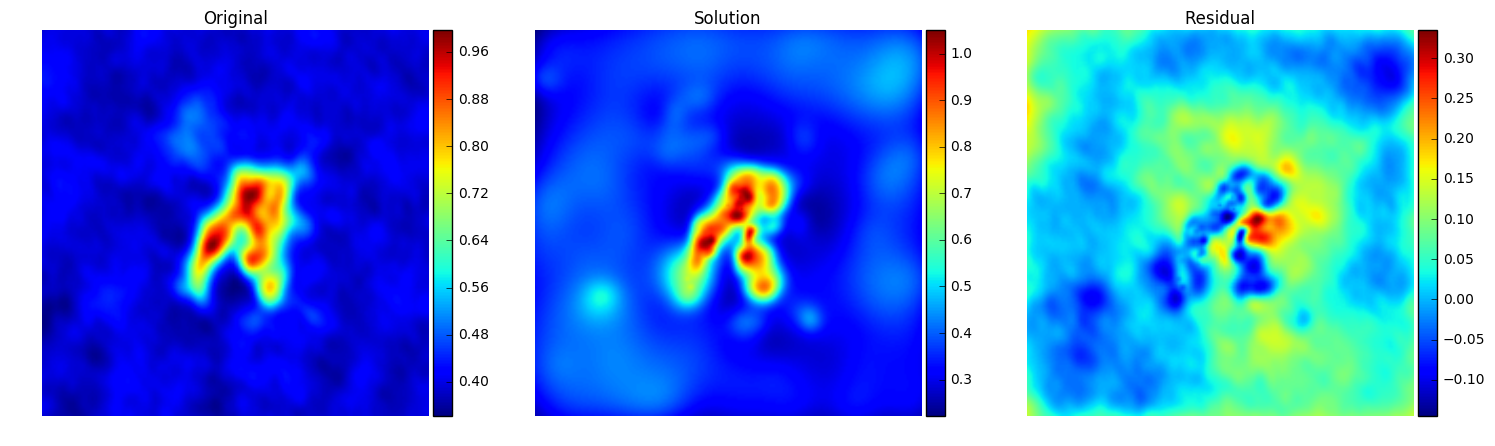

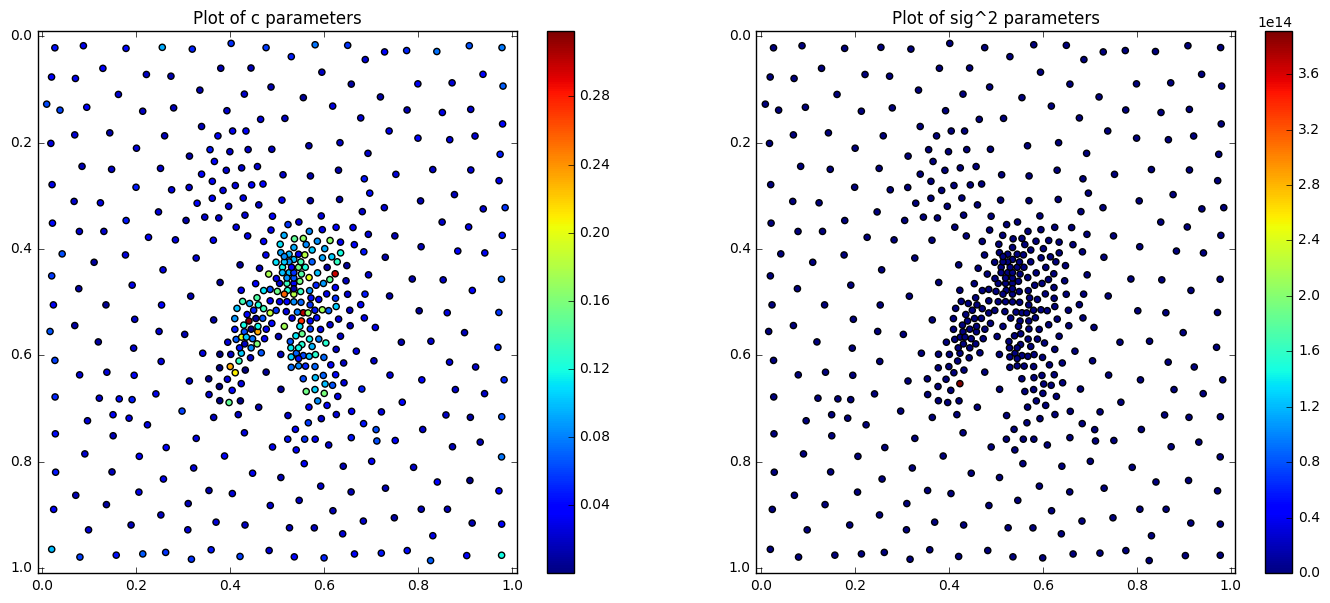

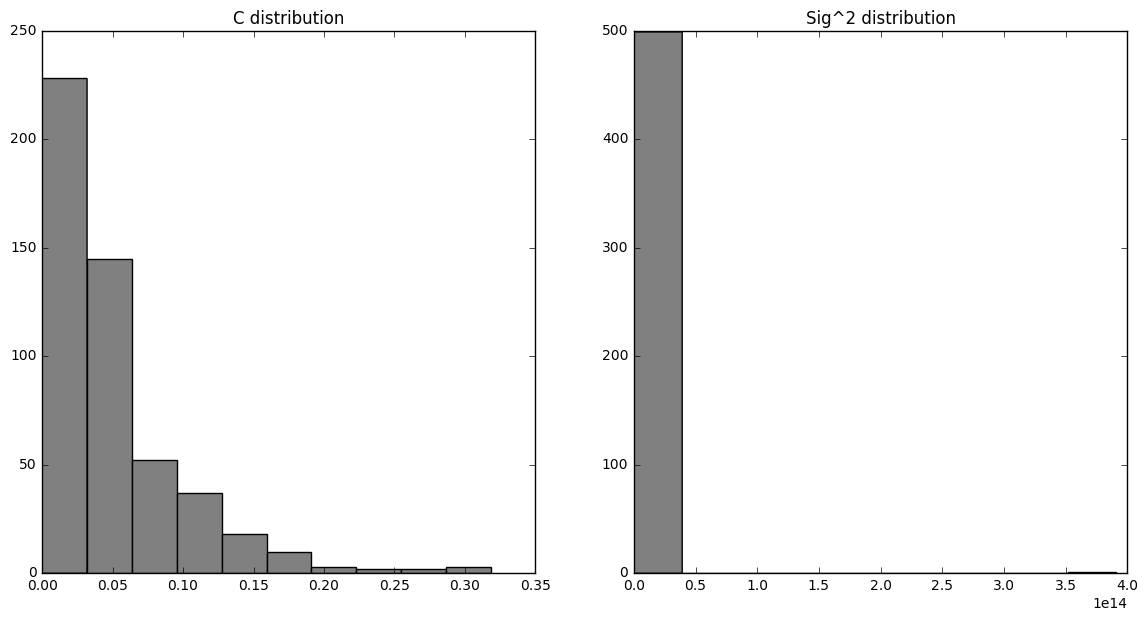

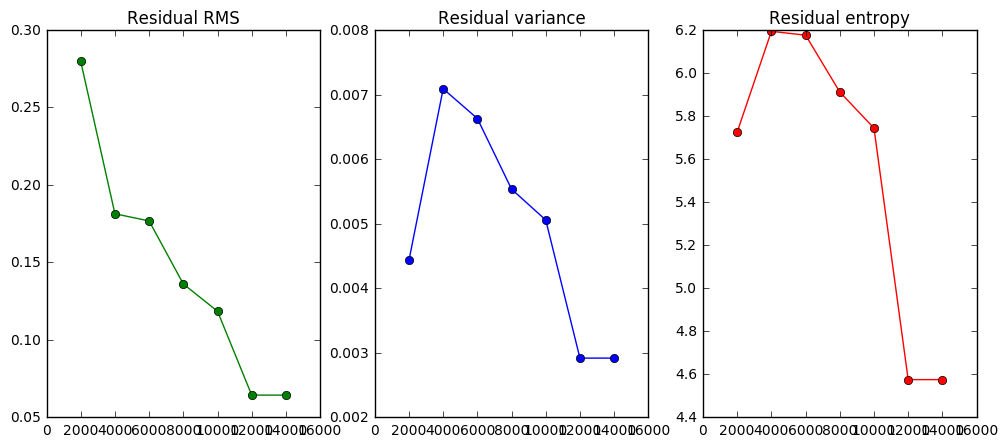

In [50]:
el_solver(elf03, method='exact', base_level=0., square_c=True, step_iter=2000, max_iter=50000)


########################################################################################################################
Results after 2000 iterations
########################################################################################################################
Variation on c = 1.02407989462
variation on sig = 0.760044221842

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2007

########################################################################################################################
Results after 4000 iterations
########################################################################################################################
Variation on c = 0.303132096195
variation on sig = 0.0778971573859

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2007

#################################################################################################################

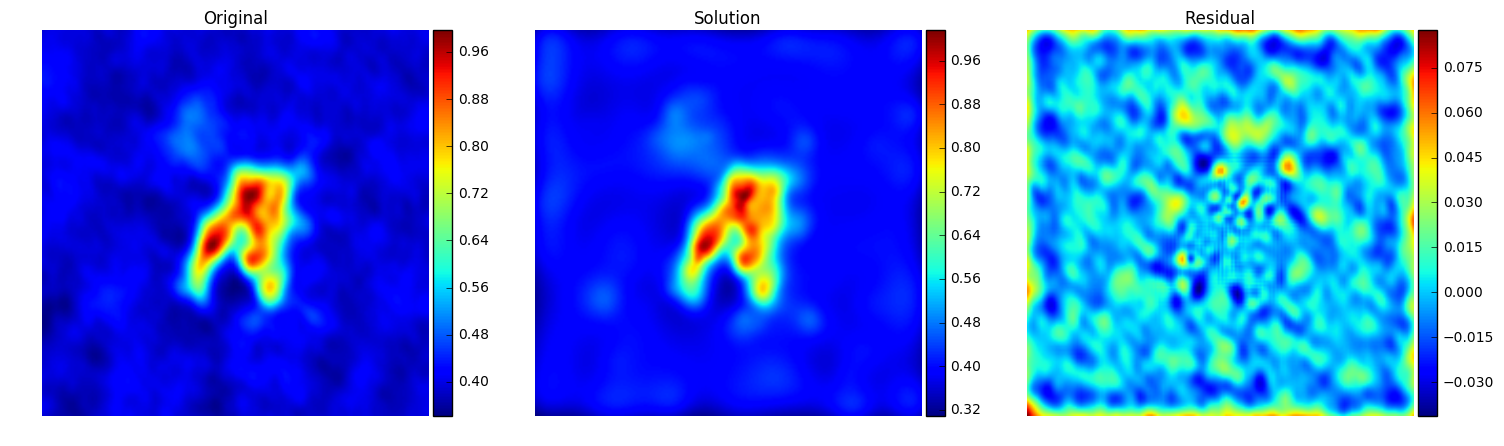

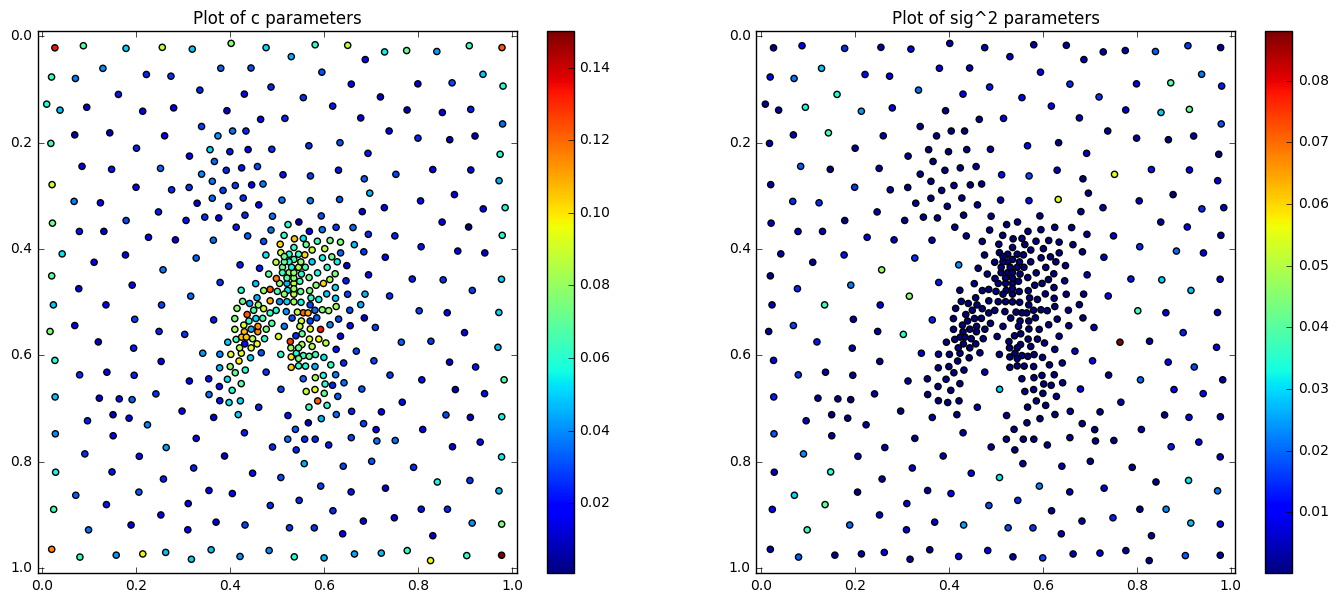

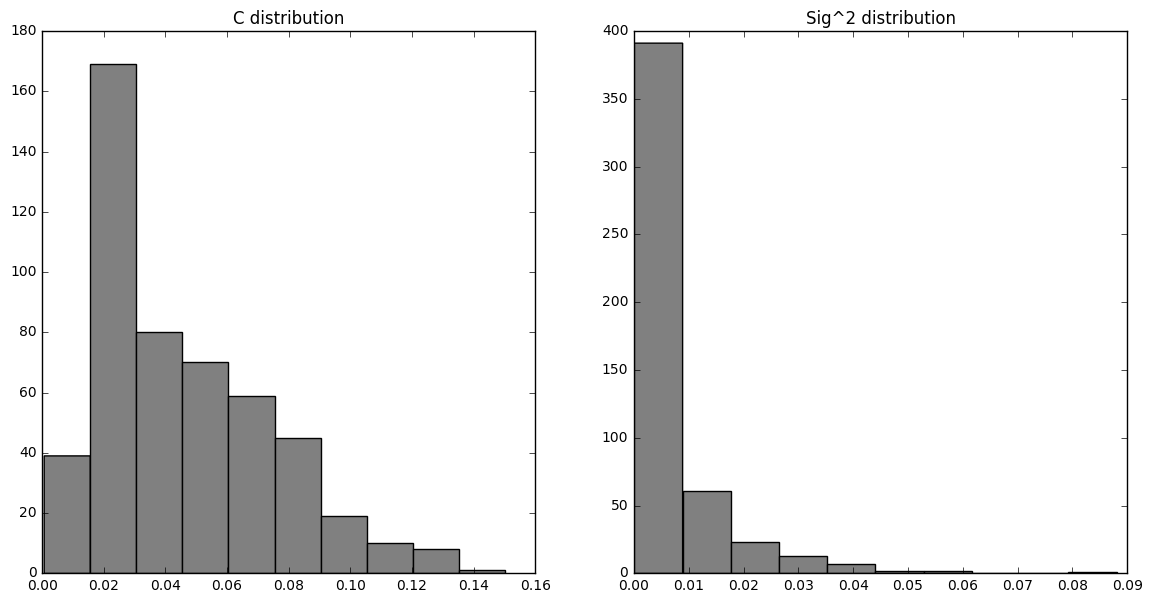

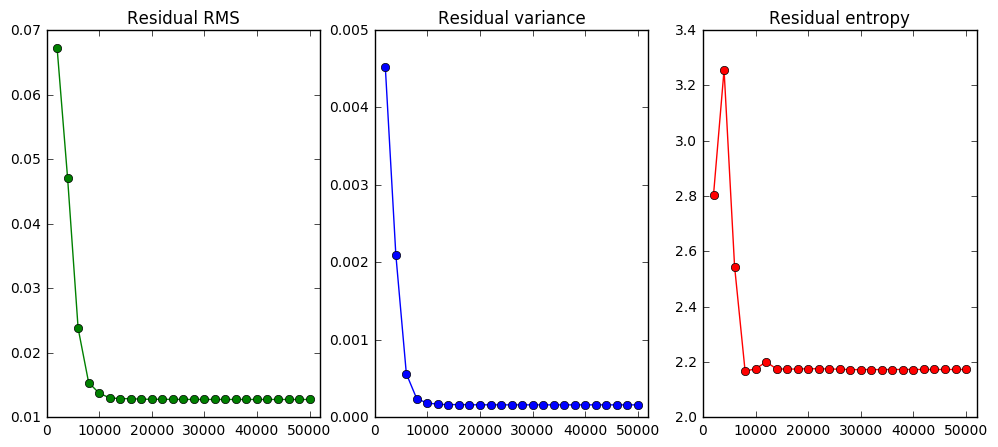

In [52]:
el_solver(elf04, method='exact', base_level=0., square_c=True, step_iter=2000, max_iter=50000)

## Greater penalty on flux addition term

In [54]:
"""
ELFunc instantiations
"""

elf05 = ELFunc(f, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=5., lamb1=1., b=0., lamb2=1.,
               d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=0., square_c=True, compact_supp=False)

elf06 = ELFunc(f, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=1., lamb1=5., b=0., lamb2=1.,
               d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=0., square_c=True, compact_supp=False)

elf07 = ELFunc(f, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=5., lamb1=5., b=0., lamb2=1.,
               d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=0., square_c=True, compact_supp=False)


########################################################################################################################
Results after 2000 iterations
########################################################################################################################
Variation on c = 0.740618503139
variation on sig = 0.558279836742

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

########################################################################################################################
Results after 4000 iterations
########################################################################################################################
Variation on c = 0.394344151499
variation on sig = 0.236663143569

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

#################################################################################################################

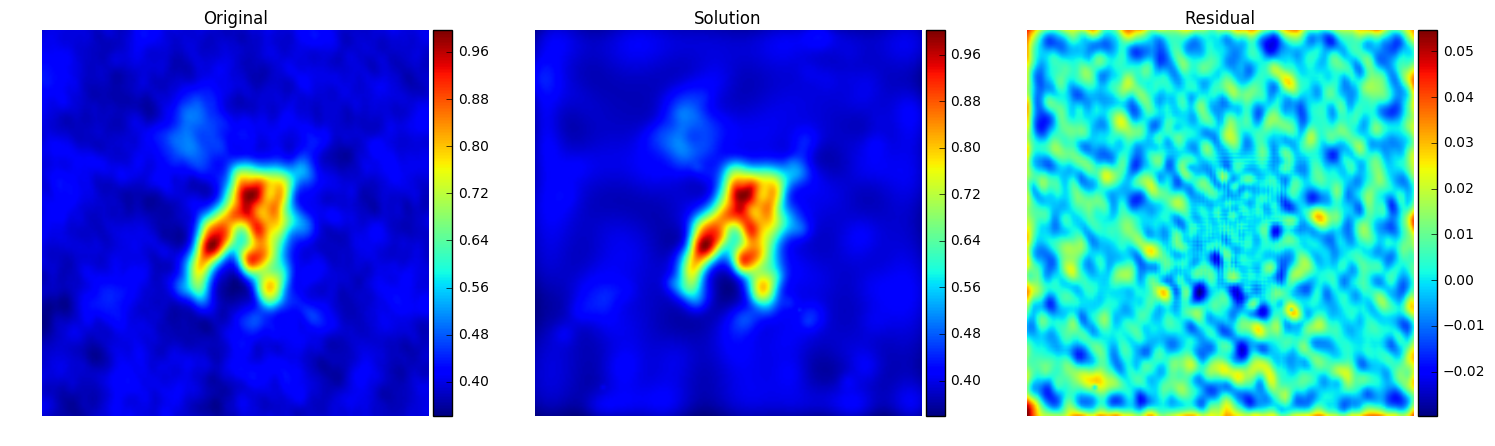

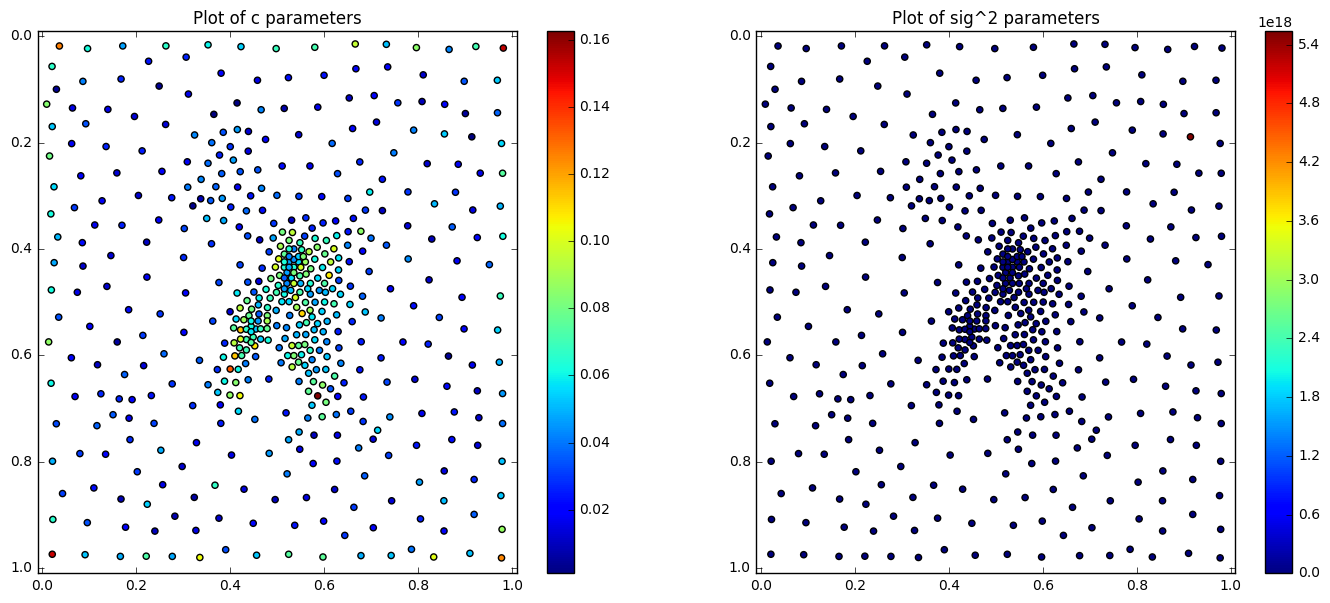

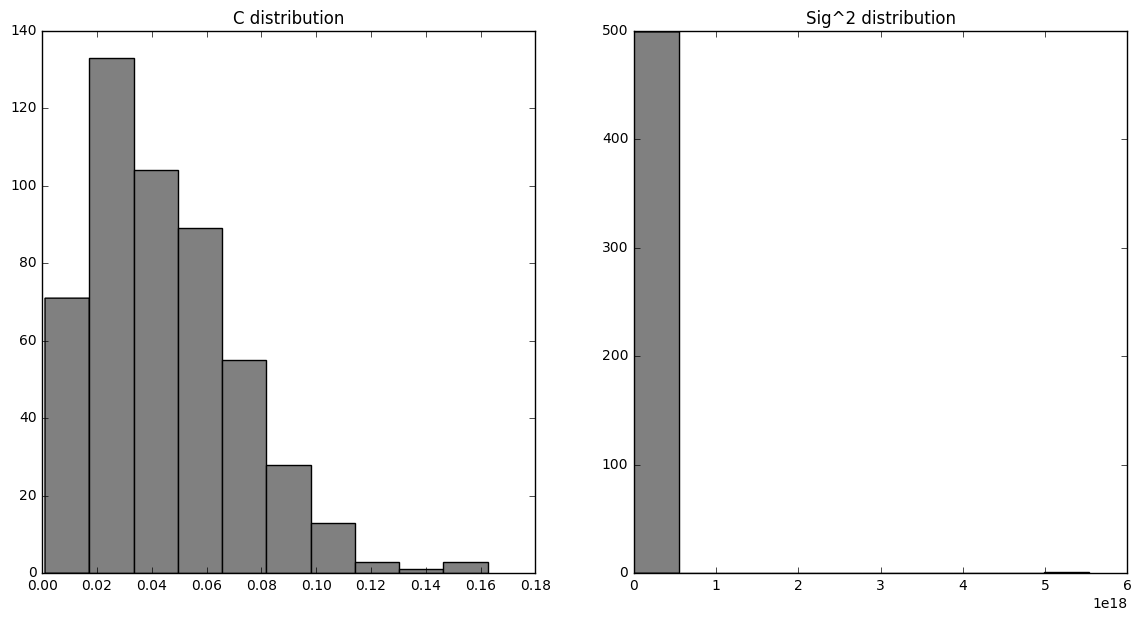

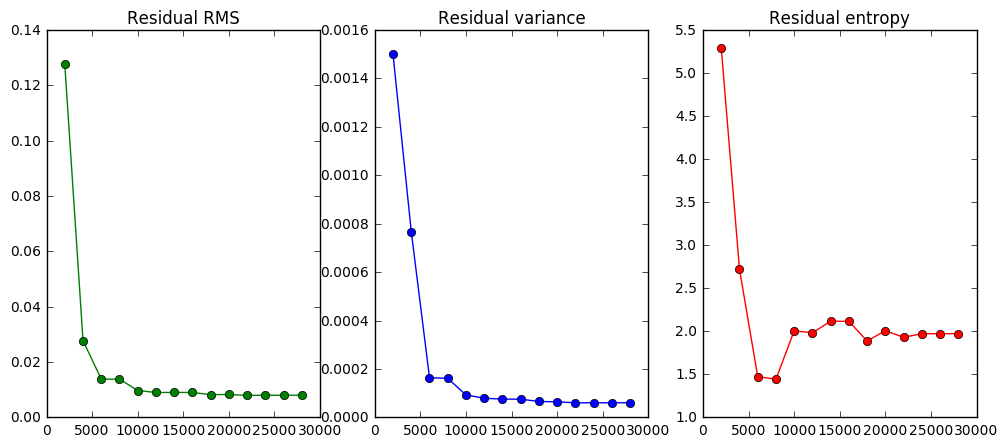

In [49]:
el_solver(elf05, method='exact', base_level=0., square_c=True, step_iter=2000, max_iter=50000)


########################################################################################################################
Results after 2000 iterations
########################################################################################################################
Variation on c = 0.740618503139
variation on sig = 0.558279836742

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

########################################################################################################################
Results after 4000 iterations
########################################################################################################################
Variation on c = 0.0906134977214
variation on sig = 0.0544864534952

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2007

###############################################################################################################

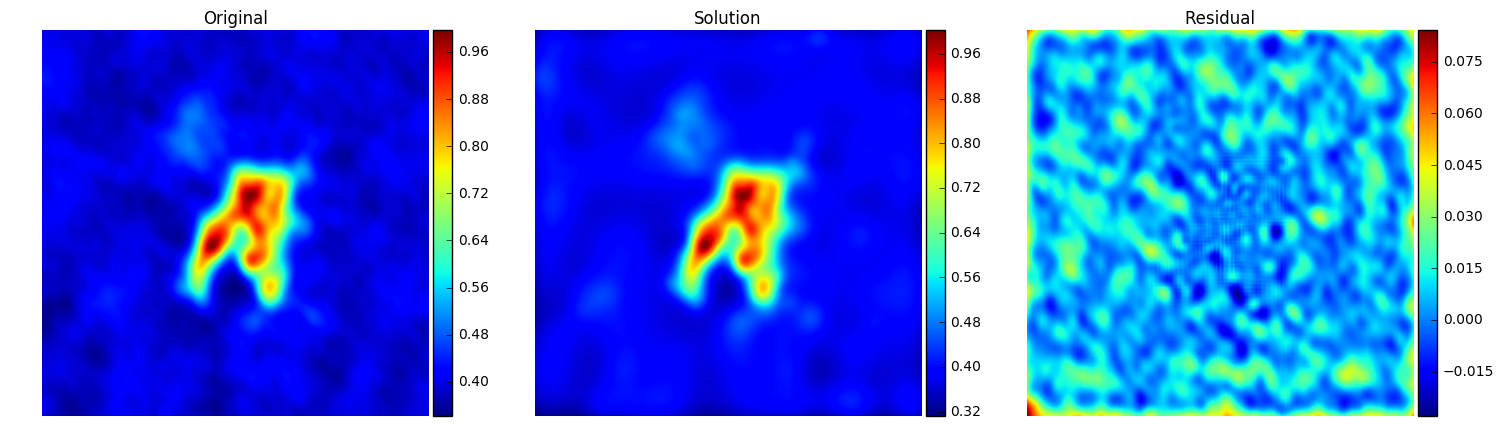

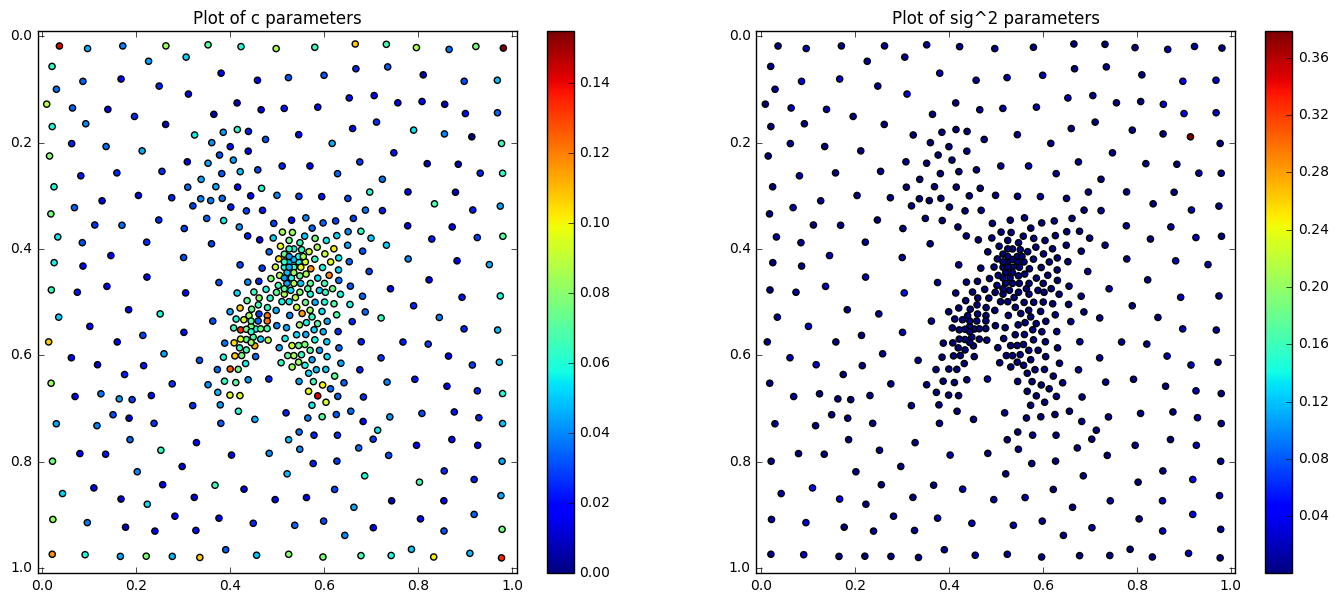

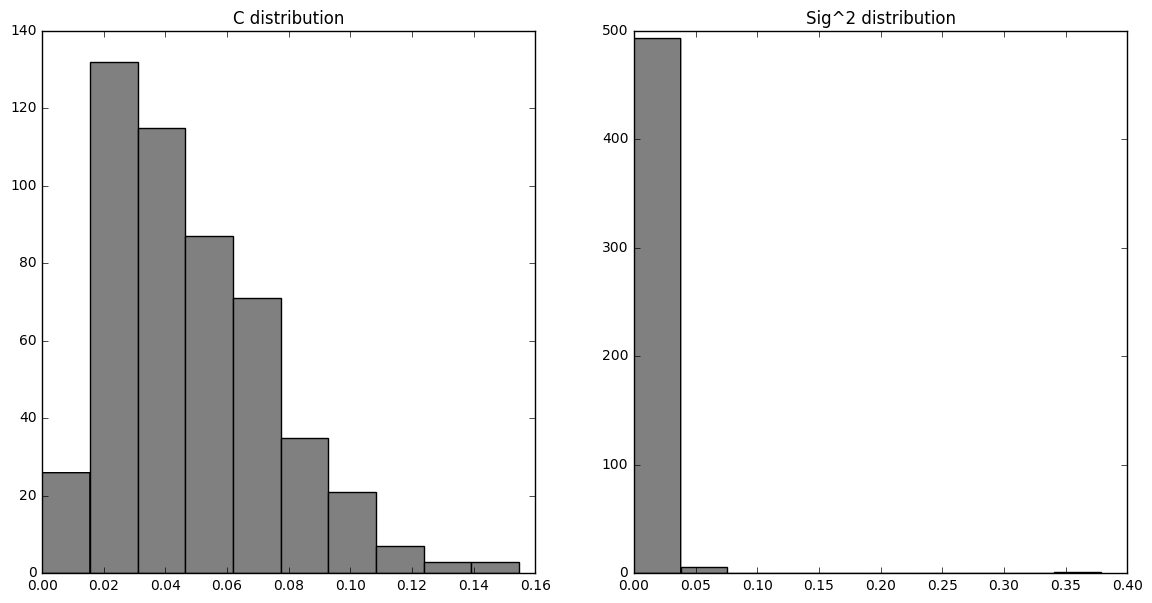

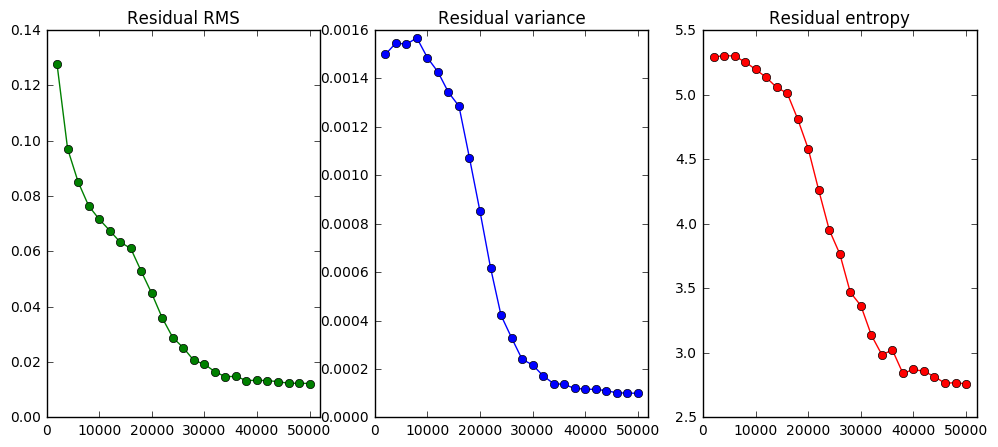

In [51]:
el_solver(elf06, method='exact', base_level=0., square_c=True, step_iter=2000, max_iter=50000)


########################################################################################################################
Results after 2000 iterations
########################################################################################################################
Variation on c = 0.740618503139
variation on sig = 0.558279836742

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

########################################################################################################################
Results after 4000 iterations
########################################################################################################################
Variation on c = 0.011084773641
variation on sig = 0.00994687372165

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2008

###############################################################################################################

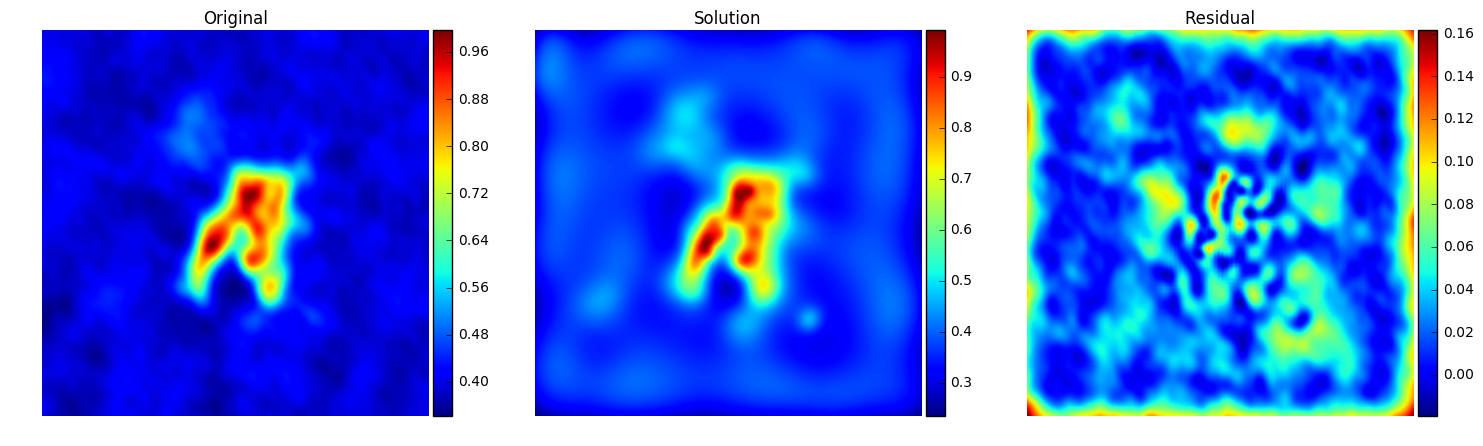

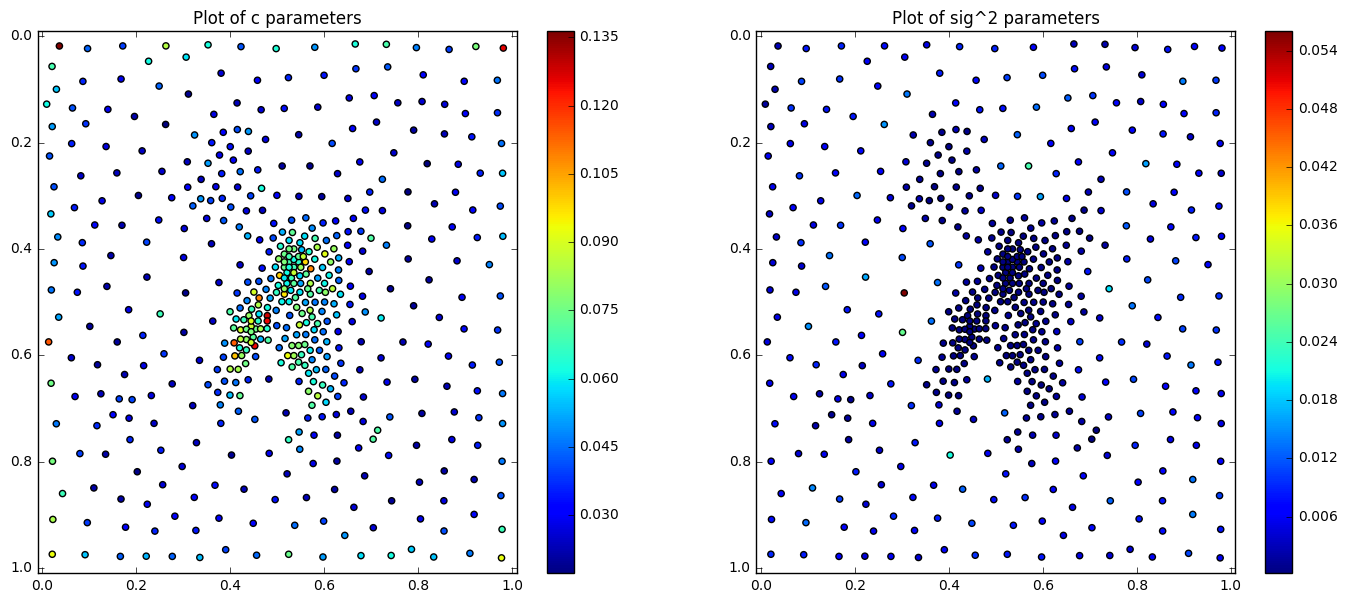

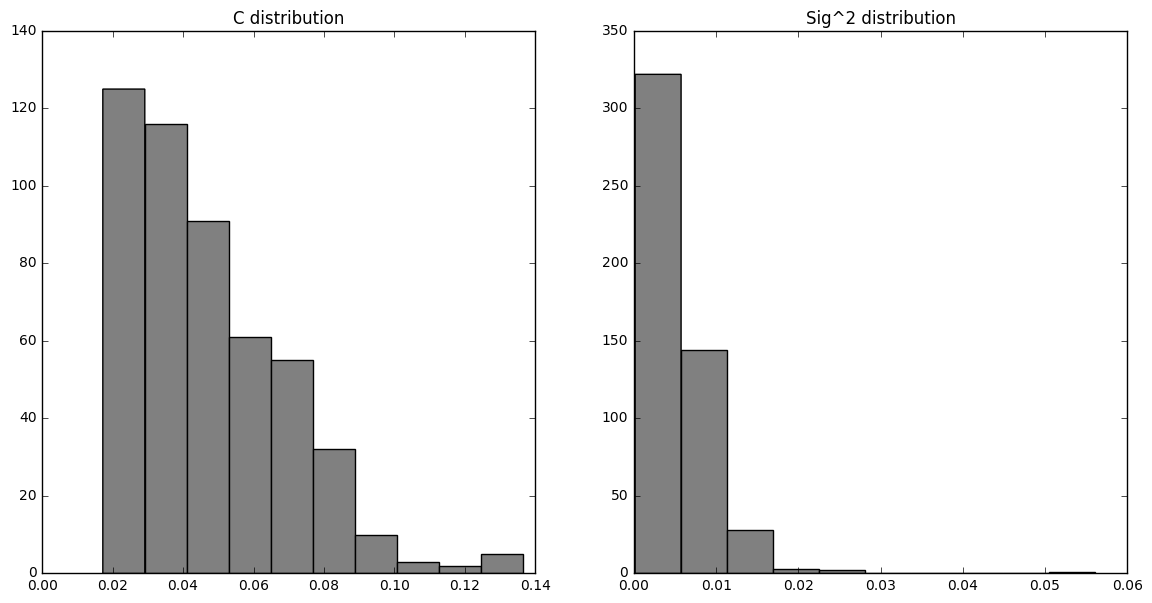

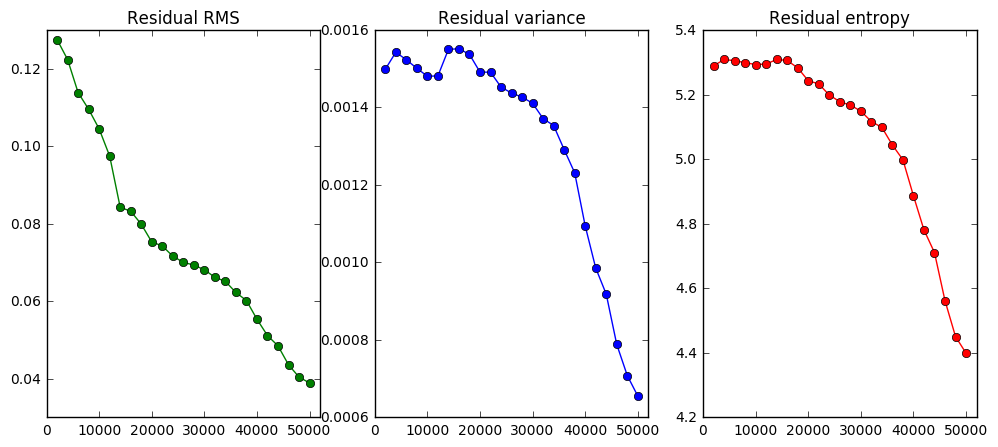

In [55]:
el_solver(elf07, method='exact', base_level=0., square_c=True, step_iter=2000, max_iter=50000)